In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from src.sanity import *

from src.load_datasets import load_air_polution_data

from src.utils import (
    show_dataset,
    show_series,
    plot_metrics,
    test_train_split,
    seperate_target,
    plot_tf_training_history,
)

from src.features import (
    create_lag_feature,
    create_datetime_feature,
    create_cyclic_feature,
    create_window_feature,
    drop_null_rows,
    create_target_vars,
)

from src.evaluation import evaluate

In [5]:
np.random.seed(80)
plt.style.use("seaborn-v0_8-darkgrid")
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

%config InlineBackend.figure_format = 'retina'

In [6]:
dataframe = (
    load_air_polution_data()
    .pipe(format_datetime, col="date")
    .pipe(set_index, col="date")
    .pipe(interpolate_column, cols="pollution")
    .pipe(resample_Data, freq="D")
)

print(f"dataframe shape {dataframe.shape}")

print(dataframe.info())

dataframe.head()

format_datetime: DF Shape (43800, 9)
set_index: DF Shape (43800, 8)
interpolate_columns: DF Shape (43800, 8)
resample_Data: DF Shape (1825, 7)
dataframe shape (1825, 7)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1825 entries, 2010-01-02 to 2014-12-31
Freq: D
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pollution  1825 non-null   float64
 1   dewp       1825 non-null   float64
 2   temp       1825 non-null   float64
 3   press      1825 non-null   float64
 4   wnd_spd    1825 non-null   float64
 5   snow       1825 non-null   float64
 6   rain       1825 non-null   float64
dtypes: float64(7)
memory usage: 114.1 KB
None


,pollution,dewp,temp,press,wnd_spd,snow,rain
date,,,,,,,
2010-01-02,145.958333,-8.500000,-5.125000,1024.750000,24.860000,0.708333,0.0
2010-01-03,78.833333,-10.125000,-8.541667,1022.791667,70.937917,14.166667,0.0
2010-01-04,31.333333,-20.875000,-11.500000,1029.291667,111.160833,0.000000,0.0
2010-01-05,42.458333,-24.583333,-14.458333,1033.625000,56.920000,0.000000,0.0
2010-01-06,56.416667,-23.708333,-12.541667,1033.750000,18.511667,0.000000,0.0


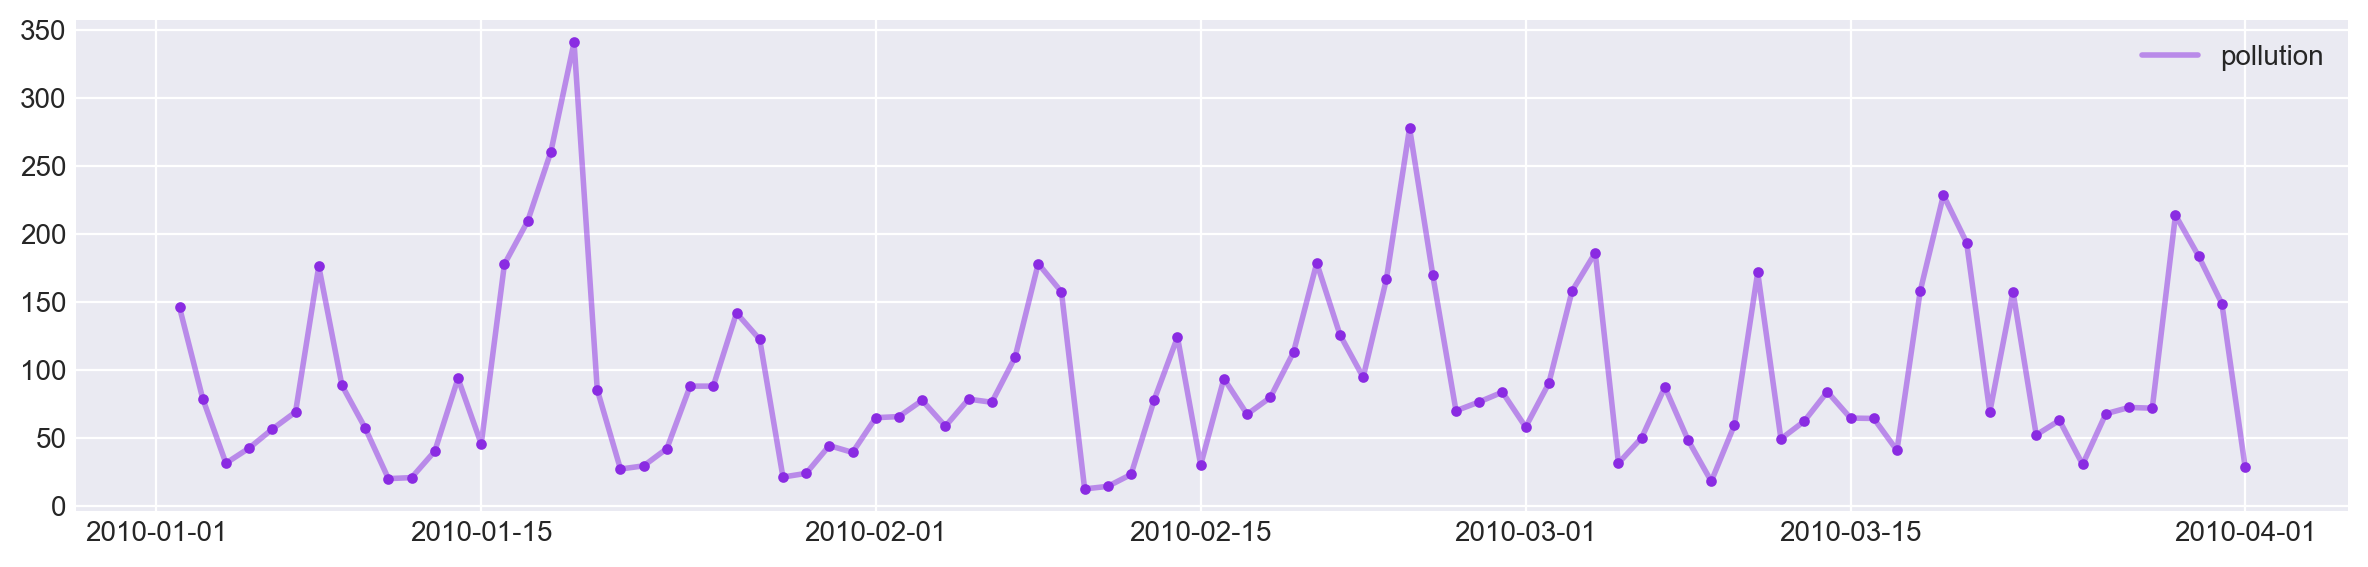

In [7]:
show_dataset(dataframe[:90], columns=["pollution"])

In [8]:
DT_FEATURES = [
    "dayofweek",
    "quarter",
    "month",
    "year",
    "dayofyear",
    "dayofmonth",
    "weekofyear",
    "dayofweek",
    "is_week_end",
    "is_week_day",
]
CYCLIC_FEATURE = ["day", "month", "year"]
LAGS = [1, 2]
FEATURE_WINDOW_LEN = 3

TARGET_COLUMN = "pollution"
TEST_SIZE = 60
OUTPUT_SEQUENCE_LEN = 9

In [6]:
print(f"dataframe shape {dataframe.shape}")


build_features = lambda df: (
    df.pipe(create_lag_feature, column=TARGET_COLUMN, lags=LAGS)
    .pipe(create_window_feature, column=TARGET_COLUMN, window_len=FEATURE_WINDOW_LEN)
    .pipe(create_datetime_feature, features_name=DT_FEATURES)
    .pipe(create_cyclic_feature, features_name=CYCLIC_FEATURE)
    .pipe(drop_null_rows)
)

df_feat = build_features(dataframe)

print(f"train_data shape after Feature Union {df_feat.shape}", end="\n\n")

train_data, test_data = test_train_split(df_feat, test_size=TEST_SIZE)

print(f"Train Size after Test_Train Split: {train_data.shape}")
print(f"Test  Size after Test_Train Split: {test_data.shape} ")

train_x, train_y = seperate_target(train_data, TARGET_COLUMN)
test_x, test_y = seperate_target(test_data, TARGET_COLUMN)

print(f"train_data shape after seperate_target {train_data_feat.shape}")
print(f"test_data shape after seperate_target {test_data_feat.shape}")

train_y, target_cols = create_target_vars(train_y, target_column, OUTPUT_SEQUENCE_LEN)
test_y, target_cols = create_target_vars(test_y, target_column, OUTPUT_SEQUENCE_LEN)

train_x = train_x[:-OUTPUT_SEQUENCE_LEN]
test_x = test_x[:-OUTPUT_SEQUENCE_LEN]

train_y = train_y[:-OUTPUT_SEQUENCE_LEN]
test_y = test_y[:-OUTPUT_SEQUENCE_LEN]

print(f"train_x shape {train_x.shape}")
print(f"test_x shape {test_x.shape}")

print(f"target_train_df shape {train_y.shape}")
print(f"target_test_df shape {test_y.shape}")

Train Size after Test_Train Split: (1756, 7)
Test  Size after Test_Train Split: (69, 7) 
train_data shape after Feature Union (1756, 26)
test_data shape after Feature Union (69, 26)
train_data shape after Null Removal (1754, 26)
test_data shape after Null Removal (69, 26)
train_x shape (1745, 25)
test_x shape (60, 25)
target_train_df shape (1745, 10)
target_test_df shape (60, 10)


In [7]:
print(
    train_x.isna().sum().sum(),
    test_x.isna().sum().sum(),
    train_y.isna().sum().sum(),
    test_y.isna().sum().sum(),
)

0 0 0 0


In [8]:
resultsDict = {}
predictionsDF = pd.DataFrame(index=test_x.index)

### KNeighborsRegressor

In [19]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

model_name = "KNeighborsRegressor"

estimator_ = Pipeline(
    [
        ("scaler", StandardScaler()),
        (
            "regressor",
            KNeighborsRegressor(n_neighbors=2),
        ),
    ]
)

param_grid = {"regressor__n_neighbors": [5, 7, 12, 15, 20, 25, 30]}

cross_validator = TimeSeriesSplit(n_splits=3)

gsearch = GridSearchCV(
    estimator=estimator_,
    cv=cross_validator,
    param_grid=param_grid,
    refit=True,
    verbose=3,
    n_jobs=1,
)

gsearch.fit(train_x, train_y)

print(gsearch.best_score_, gsearch.best_params_)

model = gsearch.best_estimator_

yhat = model.predict(test_x)

resultsDict[model_name] = evaluate(test_y, yhat)
predictionsDF[model_name] = yhat[:, 0]

Fitting 3 folds for each of 7 candidates, totalling 21 fits
[CV 1/3] END .........regressor__n_neighbors=5;, score=-0.182 total time=   0.0s
[CV 2/3] END .........regressor__n_neighbors=5;, score=-0.100 total time=   0.0s
[CV 3/3] END .........regressor__n_neighbors=5;, score=-0.075 total time=   0.0s
[CV 1/3] END .........regressor__n_neighbors=7;, score=-0.106 total time=   0.0s
[CV 2/3] END .........regressor__n_neighbors=7;, score=-0.048 total time=   0.0s
[CV 3/3] END .........regressor__n_neighbors=7;, score=-0.004 total time=   0.0s
[CV 1/3] END ........regressor__n_neighbors=12;, score=-0.009 total time=   0.0s
[CV 2/3] END ........regressor__n_neighbors=12;, score=-0.016 total time=   0.0s
[CV 3/3] END .........regressor__n_neighbors=12;, score=0.046 total time=   0.0s
[CV 1/3] END .........regressor__n_neighbors=15;, score=0.004 total time=   0.0s
[CV 2/3] END ........regressor__n_neighbors=15;, score=-0.002 total time=   0.0s
[CV 3/3] END .........regressor__n_neighbors=15;,

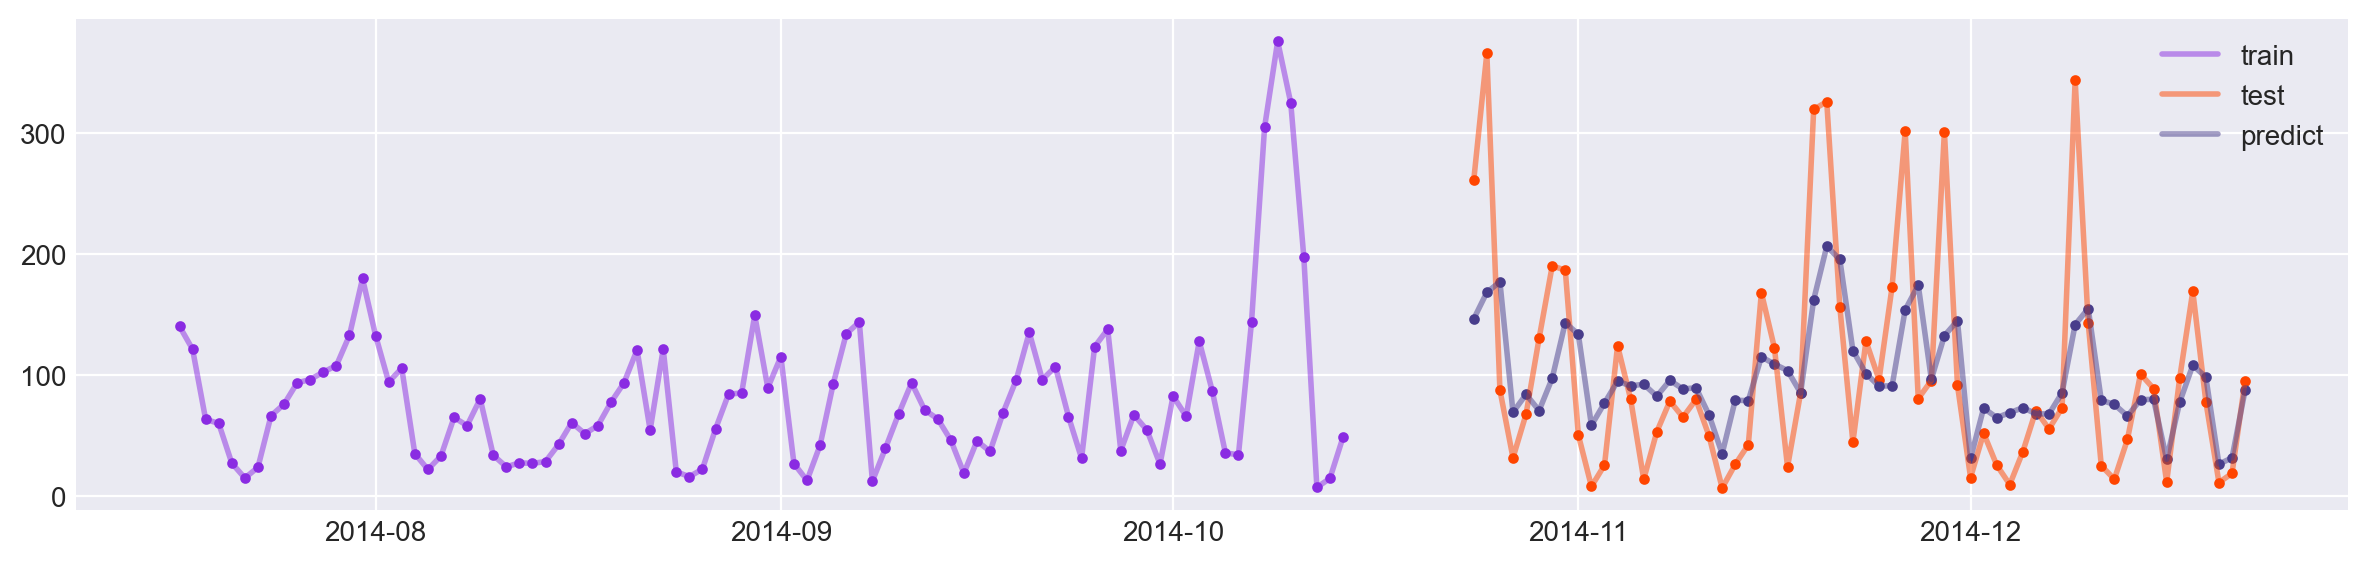

In [20]:
show_series(
    [train_y[target_column][-90:], test_y[target_column], predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

### Ridge Model

In [24]:
from sklearn.linear_model import BayesianRidge
from sklearn.multioutput import MultiOutputRegressor

model, yhat, model_name = None, None, None
model_name = "BayesianRidge"

model = Pipeline(
    [
        ("scaler", StandardScaler()),
        (
            "regressor",
            MultiOutputRegressor(
                BayesianRidge(fit_intercept=True, verbose=True, compute_score=True)
            ),
        ),
    ]
)


model.fit(train_x, train_y)
yhat = model.predict(test_x)

resultsDict[model_name] = evaluate(test_y, yhat)
predictionsDF[model_name] = yhat[:, 0]

Convergence after  5  iterations
Convergence after  8  iterations
Convergence after  21  iterations
Convergence after  20  iterations
Convergence after  10  iterations
Convergence after  8  iterations
Convergence after  8  iterations
Convergence after  8  iterations
Convergence after  9  iterations
Convergence after  9  iterations


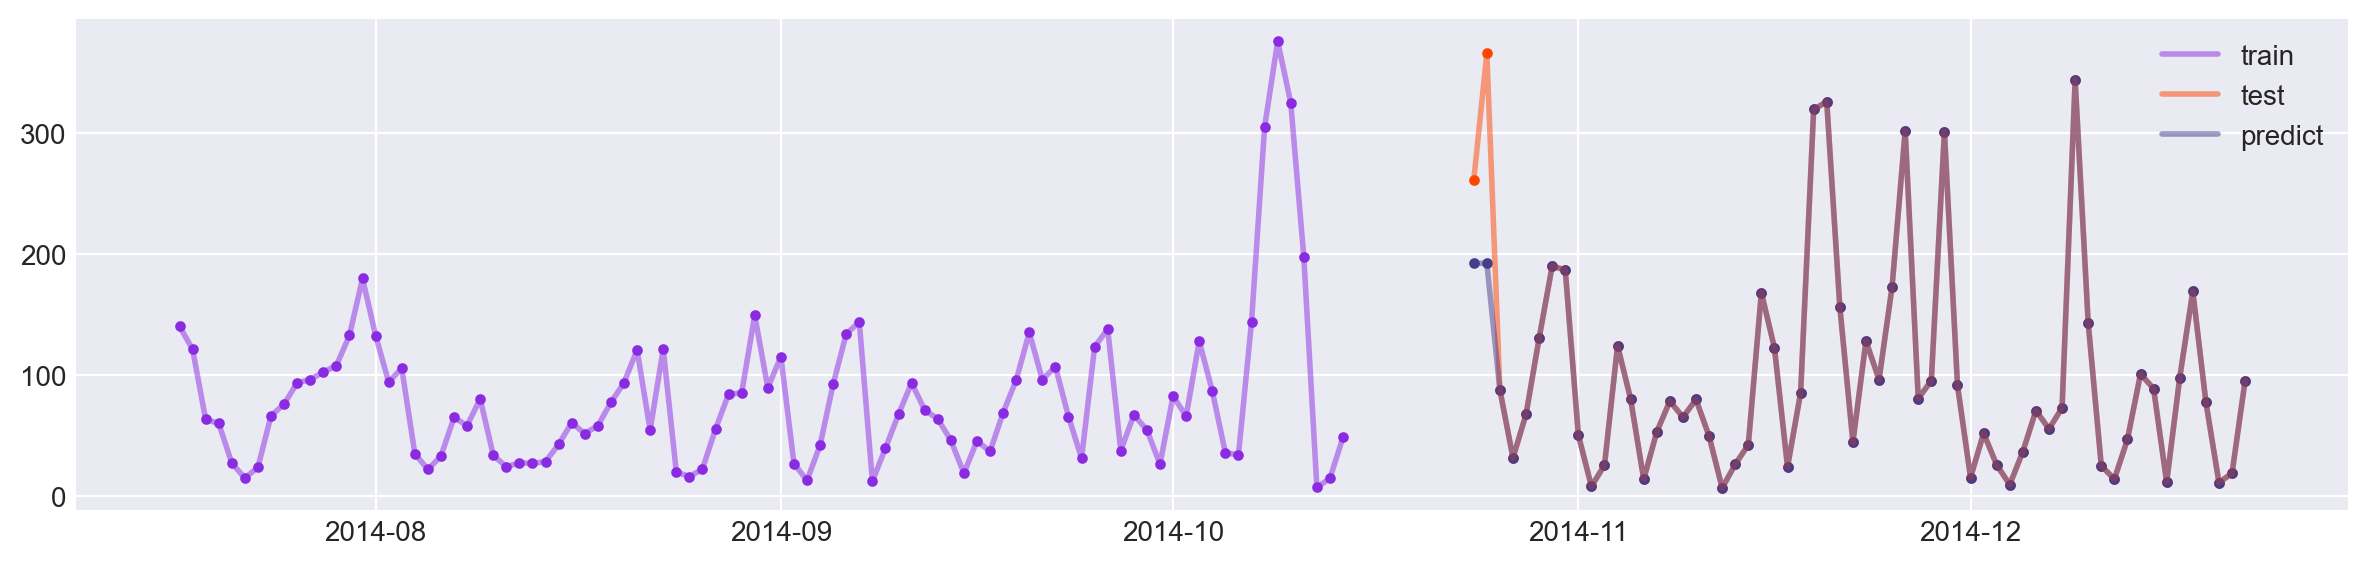

In [25]:
show_series(
    [train_y[target_column][-90:], test_y[target_column], predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

### LassoCV Regressor

In [32]:
from sklearn.linear_model import LassoCV, MultiTaskLassoCV
from sklearn.model_selection import TimeSeriesSplit

model, yhat, model_name = None, None, None

model_name = "LassoCV"

cross_validator = TimeSeriesSplit(n_splits=3)

model = Pipeline(
    [
        ("scaler", StandardScaler()),
        (
            "regressor",
            MultiTaskLassoCV(
                fit_intercept=True,
                cv=cross_validator,
                random_state=80,
                max_iter=5000,
                verbose=True,
            ),
        ),
    ]
)

model.fit(train_x, train_y)
yhat = model.predict(test_x)

resultsDict[model_name] = evaluate(test_y, yhat)
predictionsDF[model_name] = yhat[:, 0]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
............................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.1s finished


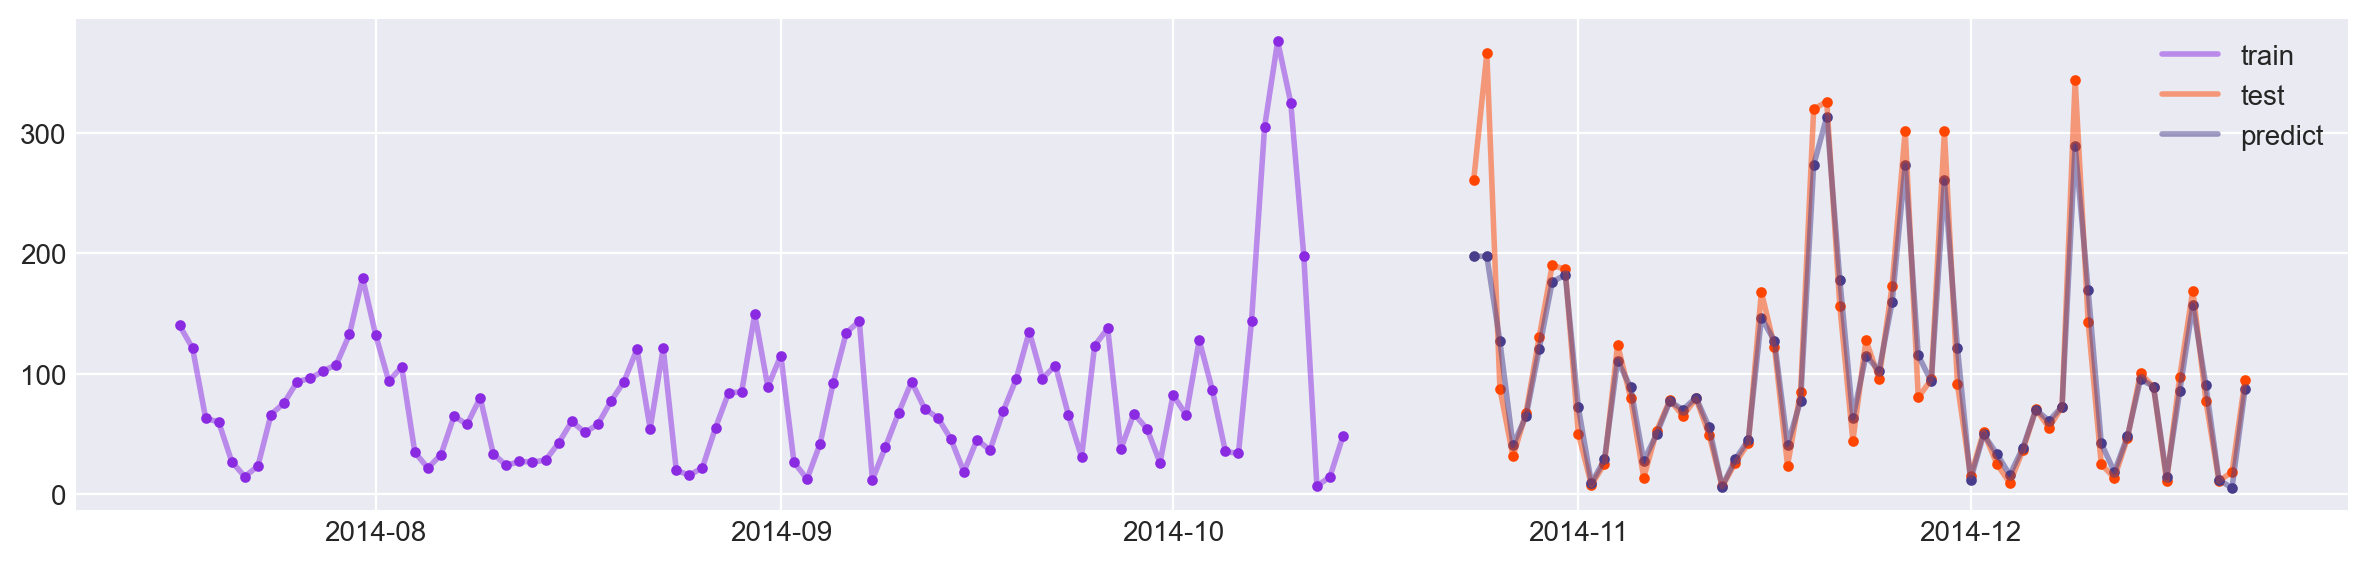

In [33]:
show_series(
    [train_y[target_column][-90:], test_y[target_column], predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

### Random Forest Regressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

model, yhat, model_name = None, None, None

model_name = "RandomForestRegressor"

# Best Params {'max_depth': 9, 'min_samples_leaf': 2, 'min_samples_split': 7, 'n_estimators': 500}

param_grid = {
    #'bootstrap': [True,False],
    # "max_depth": [7, 8, 9],
    # "min_samples_leaf": [2, 3],
    # "min_samples_split": [7, 8],
    # "n_estimators": [300, 500, 600],
    "max_depth": [9],
    "min_samples_leaf": [2],
    "min_samples_split": [7],
    "n_estimators": [500],
}

estimator_ = RandomForestRegressor(random_state=80)


cross_validator = TimeSeriesSplit(n_splits=3)

gsearch = GridSearchCV(
    estimator=estimator_,
    cv=cross_validator,
    param_grid=param_grid,
    refit=True,
    verbose=3,
    n_jobs=1,
)

# gsearch.fit(train_x_scaled, train_y.to_numpy().flatten())


gsearch.fit(train_x, train_y)

print(gsearch.best_score_, gsearch.best_params_)

model = gsearch.best_estimator_

yhat = model.predict(test_x)

resultsDict[model_name] = evaluate(test_y, yhat)
predictionsDF[model_name] = yhat[:, 0]

In [ ]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

### XGB Regressor

[0]	validation_0-mae:97.06292	validation_1-mae:95.17004
[1]	validation_0-mae:96.11963	validation_1-mae:94.14143
[2]	validation_0-mae:95.18536	validation_1-mae:93.14083
[3]	validation_0-mae:94.26149	validation_1-mae:92.16972
[4]	validation_0-mae:93.34742	validation_1-mae:91.19509
[5]	validation_0-mae:92.44241	validation_1-mae:90.25002
[6]	validation_0-mae:91.54673	validation_1-mae:89.37001
[7]	validation_0-mae:90.66088	validation_1-mae:88.50523
[8]	validation_0-mae:89.78554	validation_1-mae:87.69442
[9]	validation_0-mae:88.92027	validation_1-mae:86.88045
[10]	validation_0-mae:88.06459	validation_1-mae:86.10847
[11]	validation_0-mae:87.21887	validation_1-mae:85.35715
[12]	validation_0-mae:86.38285	validation_1-mae:84.61603
[13]	validation_0-mae:85.56064	validation_1-mae:83.93532
[14]	validation_0-mae:84.75030	validation_1-mae:83.27469
[15]	validation_0-mae:83.95273	validation_1-mae:82.60149
[16]	validation_0-mae:83.16862	validation_1-mae:82.00448
[17]	validation_0-mae:82.39693	validation

[144]	validation_0-mae:42.28944	validation_1-mae:59.51655
[145]	validation_0-mae:42.18088	validation_1-mae:59.52992
[146]	validation_0-mae:42.08181	validation_1-mae:59.53498
[147]	validation_0-mae:41.97637	validation_1-mae:59.54076
[148]	validation_0-mae:41.87571	validation_1-mae:59.54609
[149]	validation_0-mae:41.77763	validation_1-mae:59.56573
[150]	validation_0-mae:41.68012	validation_1-mae:59.58037


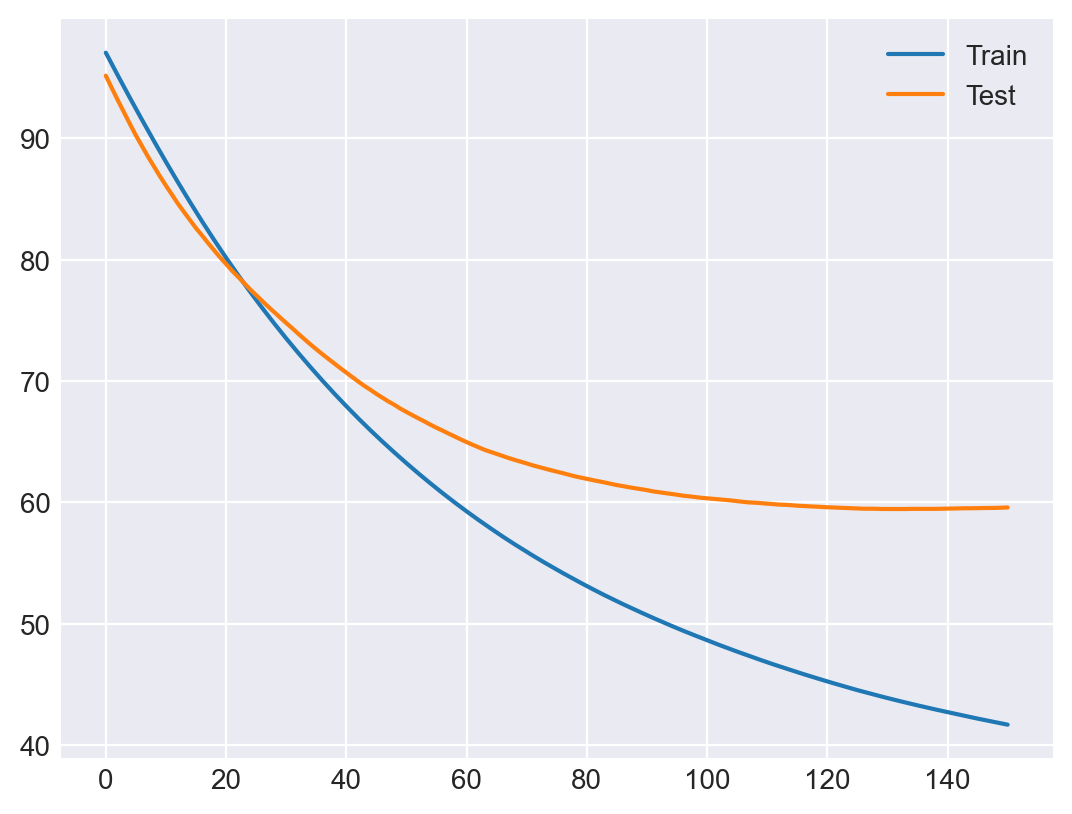

In [34]:
import xgboost as xgb

model, yhat, model_name = None, None, None

model_name = "XGBRegressor"

model = xgb.XGBRegressor(
    objective="reg:squarederror",
    n_estimators=1000,
    max_depth=6,
    learning_rate=0.01,
    tree_method="hist",
    early_stopping_rounds=20,
    eval_metric="mae",
    random_state=1,
)

model.fit(
    train_x, train_y, eval_set=[(train_x, train_y), (test_x, test_y)], verbose=True
)

yhat = model.predict(test_x)

resultsDict[model_name] = evaluate(test_y, yhat)

predictionsDF[model_name] = yhat[:, 0]

# resultsDF.head()

fig, ax = plt.subplots()
epochs = len(model.evals_result()["validation_0"]["mae"])
x_axis = range(0, epochs)
ax.plot(x_axis, model.evals_result()["validation_0"]["mae"], label="Train")
ax.plot(x_axis, model.evals_result()["validation_1"]["mae"], label="Test")
ax.legend()

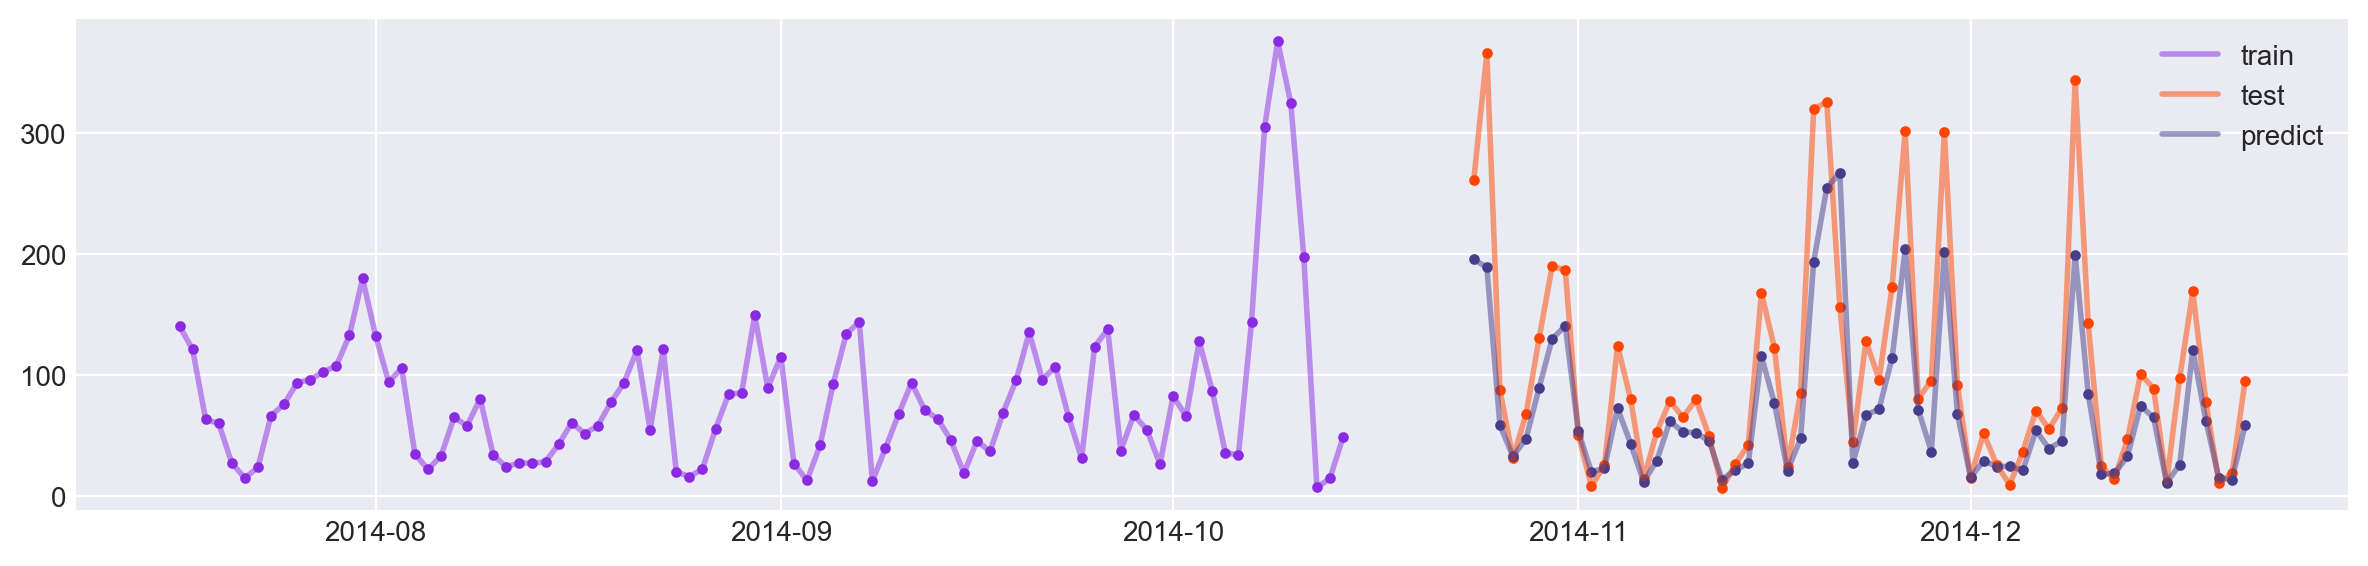

In [35]:
show_series(
    [train_y[target_column][-90:], test_y[target_column], predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

### LGBM

In [43]:
from lightgbm import LGBMRegressor, early_stopping, log_evaluation

model, yhat, model_name = None, None, None

model_name = "LGBMRegressor"

hyper_params = {
    "task": "train",
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": ["mae", "l2"],
    "learning_rate": 0.005,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.7,
    "bagging_freq": 10,
    "verbose": 0,
    "max_depth": 8,
    "num_leaves": 128,
    "max_bin": 512,
    "num_iterations": 10000,
}

model = MultiOutputRegressor(LGBMRegressor(random_state=80))

model.fit(
    train_x,
    train_y.to_numpy(),
    # eval_set=[(train_x, train_y), (test_x, test_y)],
    # eval_metric="mae",
    # callbacks=[early_stopping(stopping_rounds=5000),
    #           log_evaluation()],
)


# yhat = model.predict(test_x, num_iteration=model.best_iteration_)
yhat = model.predict(test_x)

resultsDict[model_name] = evaluate(test_y, yhat)

predictionsDF[model_name] = yhat[:, 0]

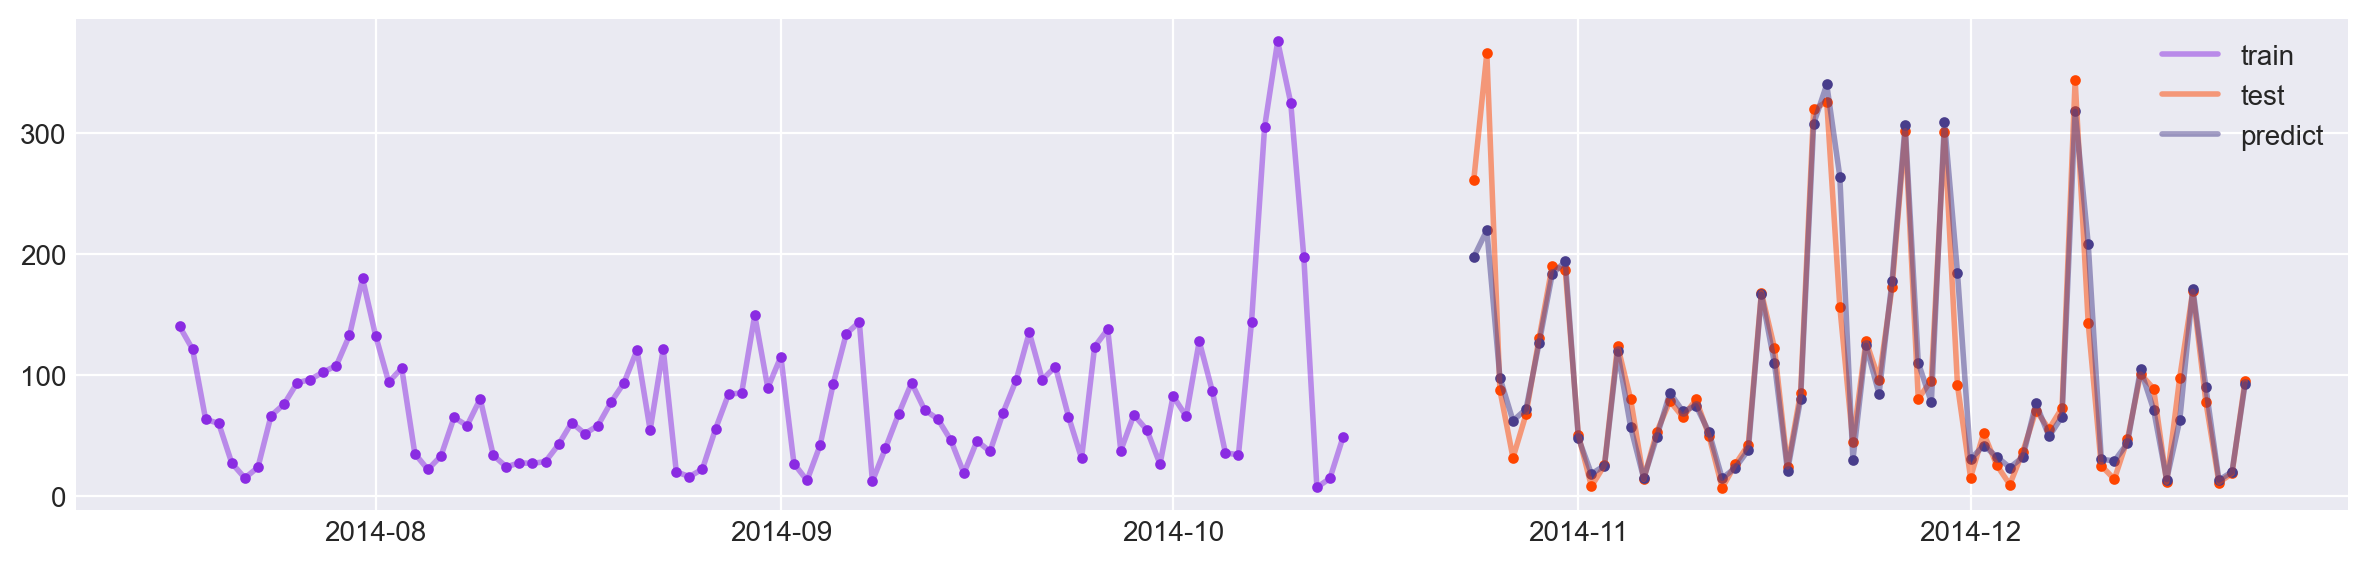

In [44]:
show_series(
    [train_y[target_column][-90:], test_y[target_column], predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

### CatBoost

In [46]:
import catboost

model, yhat, model_name = None, None, None

model_name = "CatBoostRegressor"

model = catboost.CatBoostRegressor(
    loss_function="MultiRMSE",
    eval_metric="MultiRMSE",
    learning_rate=0.1,
    depth=4,
    iterations=1000,
)

train_pool = catboost.Pool(train_x, train_y)
test_pool = catboost.Pool(test_x, test_y)

grid = {
    #    'learning_rate': [0.03, 0.1],
    #    'depth':[4, 6, 10],
    #    'l2_leaf_reg': [1, 3, 5, 7, 9]
    "l2_leaf_reg": [3, 5]
}

grid_search_results = model.grid_search(
    grid, train_pool, shuffle=False, verbose=3, refit=True, plot=False
)


print(grid_search_results["params"])

yhat = model.predict(test_x)

resultsDict[model_name] = evaluate(test_y, yhat)

predictionsDF[model_name] = yhat[:, 0]

0:	learn: 371.8747960	test: 367.2213621	best: 367.2213621 (0)	total: 167ms	remaining: 2m 46s
1:	learn: 350.4431109	test: 346.7189216	best: 346.7189216 (1)	total: 183ms	remaining: 1m 31s
2:	learn: 332.4116497	test: 329.4527873	best: 329.4527873 (2)	total: 206ms	remaining: 1m 8s
3:	learn: 316.8928567	test: 314.6354596	best: 314.6354596 (3)	total: 237ms	remaining: 58.9s
4:	learn: 303.2819467	test: 302.0776043	best: 302.0776043 (4)	total: 268ms	remaining: 53.2s
5:	learn: 291.9420416	test: 291.3699578	best: 291.3699578 (5)	total: 297ms	remaining: 49.2s
6:	learn: 281.9192813	test: 281.7508960	best: 281.7508960 (6)	total: 311ms	remaining: 44.1s
7:	learn: 273.6095554	test: 274.0171027	best: 274.0171027 (7)	total: 329ms	remaining: 40.8s
8:	learn: 266.5694886	test: 267.6467060	best: 267.6467060 (8)	total: 360ms	remaining: 39.6s
9:	learn: 260.4560266	test: 262.2011831	best: 262.2011831 (9)	total: 427ms	remaining: 42.3s
10:	learn: 254.9136734	test: 257.5509279	best: 257.5509279 (10)	total: 452ms	r

93:	learn: 203.0205515	test: 227.3024503	best: 227.1149968 (77)	total: 2.65s	remaining: 25.5s
94:	learn: 202.8674512	test: 227.2416008	best: 227.1149968 (77)	total: 2.68s	remaining: 25.5s
95:	learn: 202.6133144	test: 227.1613197	best: 227.1149968 (77)	total: 2.71s	remaining: 25.5s
96:	learn: 202.5110268	test: 227.2089918	best: 227.1149968 (77)	total: 2.74s	remaining: 25.5s
97:	learn: 202.3489306	test: 227.2306979	best: 227.1149968 (77)	total: 2.8s	remaining: 25.8s
98:	learn: 202.1119383	test: 227.2221042	best: 227.1149968 (77)	total: 2.83s	remaining: 25.8s
99:	learn: 201.9460543	test: 227.2289877	best: 227.1149968 (77)	total: 2.87s	remaining: 25.8s
100:	learn: 201.7345440	test: 227.1768725	best: 227.1149968 (77)	total: 2.9s	remaining: 25.8s
101:	learn: 201.5207559	test: 227.2044464	best: 227.1149968 (77)	total: 2.91s	remaining: 25.6s
102:	learn: 201.3245891	test: 226.8998206	best: 226.8998206 (102)	total: 2.92s	remaining: 25.5s
103:	learn: 201.1282869	test: 226.9209514	best: 226.899820

186:	learn: 186.8701058	test: 226.8144488	best: 226.4393571 (125)	total: 5.08s	remaining: 22.1s
187:	learn: 186.7735866	test: 226.7994728	best: 226.4393571 (125)	total: 5.11s	remaining: 22.1s
188:	learn: 186.6355239	test: 226.7235051	best: 226.4393571 (125)	total: 5.13s	remaining: 22s
189:	learn: 186.4732171	test: 226.8156786	best: 226.4393571 (125)	total: 5.15s	remaining: 22s
190:	learn: 186.2723077	test: 226.7640612	best: 226.4393571 (125)	total: 5.16s	remaining: 21.9s
191:	learn: 186.1501136	test: 226.7543938	best: 226.4393571 (125)	total: 5.2s	remaining: 21.9s
192:	learn: 185.9834227	test: 226.8316725	best: 226.4393571 (125)	total: 5.22s	remaining: 21.8s
193:	learn: 185.7983421	test: 226.9177798	best: 226.4393571 (125)	total: 5.26s	remaining: 21.9s
194:	learn: 185.6480630	test: 226.8934580	best: 226.4393571 (125)	total: 5.28s	remaining: 21.8s
195:	learn: 185.4048387	test: 226.8834142	best: 226.4393571 (125)	total: 5.3s	remaining: 21.8s
196:	learn: 185.2824757	test: 226.8935777	best

279:	learn: 173.7893907	test: 227.8542380	best: 226.4393571 (125)	total: 7.59s	remaining: 19.5s
280:	learn: 173.5325953	test: 227.8438040	best: 226.4393571 (125)	total: 7.61s	remaining: 19.5s
281:	learn: 173.3439472	test: 227.9027328	best: 226.4393571 (125)	total: 7.63s	remaining: 19.4s
282:	learn: 173.2646211	test: 227.9330876	best: 226.4393571 (125)	total: 7.66s	remaining: 19.4s
283:	learn: 173.1938242	test: 227.9077489	best: 226.4393571 (125)	total: 7.69s	remaining: 19.4s
284:	learn: 173.0579692	test: 227.8606694	best: 226.4393571 (125)	total: 7.71s	remaining: 19.3s
285:	learn: 172.9487613	test: 227.9028949	best: 226.4393571 (125)	total: 7.72s	remaining: 19.3s
286:	learn: 172.8728843	test: 227.9082978	best: 226.4393571 (125)	total: 7.74s	remaining: 19.2s
287:	learn: 172.7115625	test: 227.9401898	best: 226.4393571 (125)	total: 7.77s	remaining: 19.2s
288:	learn: 172.6477535	test: 227.9805855	best: 226.4393571 (125)	total: 7.82s	remaining: 19.2s
289:	learn: 172.5827119	test: 227.969265

366:	learn: 164.2528000	test: 229.0273490	best: 226.4393571 (125)	total: 9.87s	remaining: 17s
367:	learn: 164.1502870	test: 229.0417978	best: 226.4393571 (125)	total: 9.87s	remaining: 17s
368:	learn: 164.0495169	test: 229.1336588	best: 226.4393571 (125)	total: 9.88s	remaining: 16.9s
369:	learn: 164.0174265	test: 229.1725632	best: 226.4393571 (125)	total: 9.93s	remaining: 16.9s
370:	learn: 163.8956728	test: 229.1402847	best: 226.4393571 (125)	total: 9.96s	remaining: 16.9s
371:	learn: 163.8488246	test: 229.1000391	best: 226.4393571 (125)	total: 9.98s	remaining: 16.9s
372:	learn: 163.7422041	test: 229.1294483	best: 226.4393571 (125)	total: 9.99s	remaining: 16.8s
373:	learn: 163.6445421	test: 229.1215459	best: 226.4393571 (125)	total: 10s	remaining: 16.8s
374:	learn: 163.5286213	test: 229.1776468	best: 226.4393571 (125)	total: 10s	remaining: 16.7s
375:	learn: 163.4141883	test: 229.1742023	best: 226.4393571 (125)	total: 10.1s	remaining: 16.7s
376:	learn: 163.2778200	test: 229.1688425	best: 

456:	learn: 155.2753073	test: 230.3122951	best: 226.4393571 (125)	total: 12.4s	remaining: 14.7s
457:	learn: 155.1573926	test: 230.3201265	best: 226.4393571 (125)	total: 12.4s	remaining: 14.7s
458:	learn: 155.0861588	test: 230.3237389	best: 226.4393571 (125)	total: 12.4s	remaining: 14.7s
459:	learn: 155.0093894	test: 230.3835795	best: 226.4393571 (125)	total: 12.4s	remaining: 14.6s
460:	learn: 154.8792759	test: 230.4045832	best: 226.4393571 (125)	total: 12.5s	remaining: 14.6s
461:	learn: 154.7818328	test: 230.3956157	best: 226.4393571 (125)	total: 12.5s	remaining: 14.5s
462:	learn: 154.6387203	test: 230.7091575	best: 226.4393571 (125)	total: 12.6s	remaining: 14.6s
463:	learn: 154.5679545	test: 230.7208252	best: 226.4393571 (125)	total: 12.6s	remaining: 14.5s
464:	learn: 154.4610977	test: 230.7371262	best: 226.4393571 (125)	total: 12.6s	remaining: 14.5s
465:	learn: 154.3264071	test: 230.7708171	best: 226.4393571 (125)	total: 12.6s	remaining: 14.5s
466:	learn: 154.2692633	test: 230.861900

542:	learn: 147.5660763	test: 231.9409524	best: 226.4393571 (125)	total: 14.6s	remaining: 12.3s
543:	learn: 147.4199510	test: 232.1060354	best: 226.4393571 (125)	total: 14.6s	remaining: 12.2s
544:	learn: 147.3707099	test: 232.1045001	best: 226.4393571 (125)	total: 14.7s	remaining: 12.2s
545:	learn: 147.2638258	test: 232.1617675	best: 226.4393571 (125)	total: 14.7s	remaining: 12.2s
546:	learn: 147.1726170	test: 232.1607129	best: 226.4393571 (125)	total: 14.7s	remaining: 12.2s
547:	learn: 147.0694362	test: 232.1591445	best: 226.4393571 (125)	total: 14.7s	remaining: 12.1s
548:	learn: 146.9328672	test: 232.1862366	best: 226.4393571 (125)	total: 14.8s	remaining: 12.2s
549:	learn: 146.8245013	test: 232.1807647	best: 226.4393571 (125)	total: 14.8s	remaining: 12.1s
550:	learn: 146.7496918	test: 232.1425898	best: 226.4393571 (125)	total: 14.8s	remaining: 12.1s
551:	learn: 146.6707102	test: 232.1820048	best: 226.4393571 (125)	total: 14.8s	remaining: 12.1s
552:	learn: 146.5664555	test: 232.194663

628:	learn: 140.3858906	test: 232.8794588	best: 226.4393571 (125)	total: 16.8s	remaining: 9.93s
629:	learn: 140.2950966	test: 232.8695963	best: 226.4393571 (125)	total: 16.9s	remaining: 9.9s
630:	learn: 140.2097444	test: 232.8682572	best: 226.4393571 (125)	total: 16.9s	remaining: 9.88s
631:	learn: 140.1281884	test: 232.8541046	best: 226.4393571 (125)	total: 16.9s	remaining: 9.85s
632:	learn: 140.0828243	test: 232.8619237	best: 226.4393571 (125)	total: 17s	remaining: 9.83s
633:	learn: 140.0287642	test: 232.9024415	best: 226.4393571 (125)	total: 17s	remaining: 9.79s
634:	learn: 139.9889085	test: 232.8965042	best: 226.4393571 (125)	total: 17s	remaining: 9.76s
635:	learn: 139.9223815	test: 232.8753874	best: 226.4393571 (125)	total: 17s	remaining: 9.73s
636:	learn: 139.8546573	test: 232.9308761	best: 226.4393571 (125)	total: 17s	remaining: 9.71s
637:	learn: 139.7777026	test: 232.8763468	best: 226.4393571 (125)	total: 17.1s	remaining: 9.69s
638:	learn: 139.7250110	test: 232.8597423	best: 226

719:	learn: 133.7938294	test: 233.7153396	best: 226.4393571 (125)	total: 19.3s	remaining: 7.51s
720:	learn: 133.7230971	test: 233.7024424	best: 226.4393571 (125)	total: 19.3s	remaining: 7.49s
721:	learn: 133.6679630	test: 233.8359085	best: 226.4393571 (125)	total: 19.4s	remaining: 7.46s
722:	learn: 133.5850690	test: 233.8518892	best: 226.4393571 (125)	total: 19.4s	remaining: 7.43s
723:	learn: 133.5368764	test: 233.8638564	best: 226.4393571 (125)	total: 19.4s	remaining: 7.4s
724:	learn: 133.4596526	test: 233.8907709	best: 226.4393571 (125)	total: 19.4s	remaining: 7.37s
725:	learn: 133.3704003	test: 233.8883011	best: 226.4393571 (125)	total: 19.5s	remaining: 7.35s
726:	learn: 133.3053507	test: 233.9277005	best: 226.4393571 (125)	total: 19.5s	remaining: 7.32s
727:	learn: 133.2292944	test: 233.9362706	best: 226.4393571 (125)	total: 19.5s	remaining: 7.29s
728:	learn: 133.1903357	test: 233.9807146	best: 226.4393571 (125)	total: 19.5s	remaining: 7.26s
729:	learn: 133.0925498	test: 233.9945952

814:	learn: 127.4691108	test: 235.2327414	best: 226.4393571 (125)	total: 22.1s	remaining: 5.01s
815:	learn: 127.4198267	test: 235.2331815	best: 226.4393571 (125)	total: 22.1s	remaining: 4.98s
816:	learn: 127.3480888	test: 235.2615336	best: 226.4393571 (125)	total: 22.1s	remaining: 4.95s
817:	learn: 127.2656758	test: 235.2714792	best: 226.4393571 (125)	total: 22.1s	remaining: 4.93s
818:	learn: 127.1833872	test: 235.2713452	best: 226.4393571 (125)	total: 22.2s	remaining: 4.9s
819:	learn: 127.1401343	test: 235.2894305	best: 226.4393571 (125)	total: 22.2s	remaining: 4.87s
820:	learn: 127.0920993	test: 235.3012764	best: 226.4393571 (125)	total: 22.2s	remaining: 4.84s
821:	learn: 127.0438643	test: 235.3000758	best: 226.4393571 (125)	total: 22.2s	remaining: 4.81s
822:	learn: 126.9551207	test: 235.3617892	best: 226.4393571 (125)	total: 22.3s	remaining: 4.79s
823:	learn: 126.8883115	test: 235.3620409	best: 226.4393571 (125)	total: 22.3s	remaining: 4.76s
824:	learn: 126.8145320	test: 235.3453526

905:	learn: 121.8888071	test: 235.8639927	best: 226.4393571 (125)	total: 24.4s	remaining: 2.54s
906:	learn: 121.8363373	test: 235.8796118	best: 226.4393571 (125)	total: 24.5s	remaining: 2.51s
907:	learn: 121.7918376	test: 235.8892331	best: 226.4393571 (125)	total: 24.5s	remaining: 2.48s
908:	learn: 121.7449889	test: 235.8629132	best: 226.4393571 (125)	total: 24.5s	remaining: 2.45s
909:	learn: 121.7062553	test: 235.8578868	best: 226.4393571 (125)	total: 24.6s	remaining: 2.43s
910:	learn: 121.6633435	test: 235.8604815	best: 226.4393571 (125)	total: 24.6s	remaining: 2.4s
911:	learn: 121.5810420	test: 235.8684544	best: 226.4393571 (125)	total: 24.6s	remaining: 2.38s
912:	learn: 121.5329023	test: 235.8600387	best: 226.4393571 (125)	total: 24.6s	remaining: 2.35s
913:	learn: 121.4802020	test: 235.8990374	best: 226.4393571 (125)	total: 24.7s	remaining: 2.32s
914:	learn: 121.4235078	test: 235.9130324	best: 226.4393571 (125)	total: 24.7s	remaining: 2.29s
915:	learn: 121.3350358	test: 235.9327458

993:	learn: 116.8908574	test: 236.6876325	best: 226.4393571 (125)	total: 26.8s	remaining: 162ms
994:	learn: 116.8135698	test: 236.6898540	best: 226.4393571 (125)	total: 26.8s	remaining: 135ms
995:	learn: 116.7103071	test: 236.6981910	best: 226.4393571 (125)	total: 26.8s	remaining: 108ms
996:	learn: 116.6463906	test: 236.7036685	best: 226.4393571 (125)	total: 26.8s	remaining: 80.7ms
997:	learn: 116.5647408	test: 236.6999117	best: 226.4393571 (125)	total: 26.9s	remaining: 53.9ms
998:	learn: 116.5318040	test: 236.7056523	best: 226.4393571 (125)	total: 26.9s	remaining: 26.9ms
999:	learn: 116.4628900	test: 236.7172224	best: 226.4393571 (125)	total: 26.9s	remaining: 0us

bestTest = 226.4393571
bestIteration = 125

0:	loss: 226.4393571	best: 226.4393571 (0)	total: 27.1s	remaining: 27.1s
0:	learn: 372.1781568	test: 367.5373713	best: 367.5373713 (0)	total: 21.7ms	remaining: 21.7s
1:	learn: 351.1041484	test: 347.3623610	best: 347.3623610 (1)	total: 66.9ms	remaining: 33.4s
2:	learn: 333.2207658	t

88:	learn: 205.2738172	test: 226.8445475	best: 226.8445475 (88)	total: 2.13s	remaining: 21.9s
89:	learn: 204.9785326	test: 226.8848593	best: 226.8445475 (88)	total: 2.17s	remaining: 21.9s
90:	learn: 204.7751366	test: 226.8272217	best: 226.8272217 (90)	total: 2.19s	remaining: 21.9s
91:	learn: 204.4796945	test: 226.6848386	best: 226.6848386 (91)	total: 2.21s	remaining: 21.8s
92:	learn: 204.3195209	test: 226.5795390	best: 226.5795390 (92)	total: 2.22s	remaining: 21.7s
93:	learn: 204.1513074	test: 226.5247110	best: 226.5247110 (93)	total: 2.25s	remaining: 21.7s
94:	learn: 203.9313207	test: 226.5062236	best: 226.5062236 (94)	total: 2.28s	remaining: 21.7s
95:	learn: 203.7466152	test: 226.5627729	best: 226.5062236 (94)	total: 2.3s	remaining: 21.7s
96:	learn: 203.6397613	test: 226.5161820	best: 226.5062236 (94)	total: 2.32s	remaining: 21.6s
97:	learn: 203.4127447	test: 226.6959228	best: 226.5062236 (94)	total: 2.33s	remaining: 21.5s
98:	learn: 203.1956439	test: 226.6366939	best: 226.5062236 (9

178:	learn: 190.8030553	test: 226.8683160	best: 226.3998404 (108)	total: 4.62s	remaining: 21.2s
179:	learn: 190.6069379	test: 227.0425688	best: 226.3998404 (108)	total: 4.65s	remaining: 21.2s
180:	learn: 190.5357912	test: 227.0368386	best: 226.3998404 (108)	total: 4.68s	remaining: 21.2s
181:	learn: 190.4465747	test: 226.9894151	best: 226.3998404 (108)	total: 4.71s	remaining: 21.2s
182:	learn: 190.1773528	test: 226.8923060	best: 226.3998404 (108)	total: 4.72s	remaining: 21.1s
183:	learn: 190.0848765	test: 226.9202314	best: 226.3998404 (108)	total: 4.75s	remaining: 21.1s
184:	learn: 189.9375942	test: 226.9049797	best: 226.3998404 (108)	total: 4.78s	remaining: 21.1s
185:	learn: 189.8442992	test: 226.8997614	best: 226.3998404 (108)	total: 4.81s	remaining: 21.1s
186:	learn: 189.6819442	test: 226.8731805	best: 226.3998404 (108)	total: 4.83s	remaining: 21s
187:	learn: 189.5847795	test: 226.8537836	best: 226.3998404 (108)	total: 4.84s	remaining: 20.9s
188:	learn: 189.5008174	test: 226.8401287	

271:	learn: 178.9639860	test: 226.5277028	best: 226.0767066 (214)	total: 7.37s	remaining: 19.7s
272:	learn: 178.8132854	test: 226.6678603	best: 226.0767066 (214)	total: 7.38s	remaining: 19.7s
273:	learn: 178.7405414	test: 226.6583659	best: 226.0767066 (214)	total: 7.39s	remaining: 19.6s
274:	learn: 178.6556903	test: 226.6585464	best: 226.0767066 (214)	total: 7.42s	remaining: 19.6s
275:	learn: 178.5492816	test: 226.9587612	best: 226.0767066 (214)	total: 7.45s	remaining: 19.5s
276:	learn: 178.4442408	test: 226.9304872	best: 226.0767066 (214)	total: 7.47s	remaining: 19.5s
277:	learn: 178.3396302	test: 227.0161831	best: 226.0767066 (214)	total: 7.49s	remaining: 19.5s
278:	learn: 178.2474290	test: 226.9655313	best: 226.0767066 (214)	total: 7.5s	remaining: 19.4s
279:	learn: 178.1424828	test: 226.9647024	best: 226.0767066 (214)	total: 7.54s	remaining: 19.4s
280:	learn: 177.9749695	test: 226.9586836	best: 226.0767066 (214)	total: 7.57s	remaining: 19.4s
281:	learn: 177.7758582	test: 227.0159162

363:	learn: 169.0484412	test: 228.0232164	best: 226.0767066 (214)	total: 8.45s	remaining: 14.8s
364:	learn: 168.9129181	test: 227.9876139	best: 226.0767066 (214)	total: 8.46s	remaining: 14.7s
365:	learn: 168.8196094	test: 227.9710762	best: 226.0767066 (214)	total: 8.47s	remaining: 14.7s
366:	learn: 168.7501888	test: 227.9728605	best: 226.0767066 (214)	total: 8.48s	remaining: 14.6s
367:	learn: 168.6016512	test: 228.0361702	best: 226.0767066 (214)	total: 8.49s	remaining: 14.6s
368:	learn: 168.5157984	test: 228.1016511	best: 226.0767066 (214)	total: 8.5s	remaining: 14.5s
369:	learn: 168.4856976	test: 228.1449637	best: 226.0767066 (214)	total: 8.51s	remaining: 14.5s
370:	learn: 168.3252081	test: 228.2063367	best: 226.0767066 (214)	total: 8.52s	remaining: 14.4s
371:	learn: 168.2428527	test: 228.2156820	best: 226.0767066 (214)	total: 8.53s	remaining: 14.4s
372:	learn: 168.1376368	test: 228.2893530	best: 226.0767066 (214)	total: 8.54s	remaining: 14.4s
373:	learn: 168.0116388	test: 228.2668369

456:	learn: 160.3001063	test: 229.5450575	best: 226.0767066 (214)	total: 10s	remaining: 11.9s
457:	learn: 160.1877300	test: 229.5572694	best: 226.0767066 (214)	total: 10s	remaining: 11.9s
458:	learn: 160.0936374	test: 229.5507368	best: 226.0767066 (214)	total: 10.1s	remaining: 11.9s
459:	learn: 160.0122775	test: 229.6131228	best: 226.0767066 (214)	total: 10.1s	remaining: 11.8s
460:	learn: 159.8700086	test: 229.6920254	best: 226.0767066 (214)	total: 10.1s	remaining: 11.8s
461:	learn: 159.7674825	test: 229.7205824	best: 226.0767066 (214)	total: 10.1s	remaining: 11.8s
462:	learn: 159.6384841	test: 230.0338221	best: 226.0767066 (214)	total: 10.1s	remaining: 11.8s
463:	learn: 159.5195593	test: 230.0581142	best: 226.0767066 (214)	total: 10.2s	remaining: 11.8s
464:	learn: 159.4689452	test: 230.0632924	best: 226.0767066 (214)	total: 10.2s	remaining: 11.7s
465:	learn: 159.3489670	test: 230.0892774	best: 226.0767066 (214)	total: 10.2s	remaining: 11.7s
466:	learn: 159.2521696	test: 230.1110716	be

542:	learn: 153.0832033	test: 230.9991533	best: 226.0767066 (214)	total: 12.5s	remaining: 10.5s
543:	learn: 152.9797981	test: 231.0201485	best: 226.0767066 (214)	total: 12.5s	remaining: 10.5s
544:	learn: 152.9279192	test: 231.0333640	best: 226.0767066 (214)	total: 12.5s	remaining: 10.4s
545:	learn: 152.8358256	test: 231.0078630	best: 226.0767066 (214)	total: 12.5s	remaining: 10.4s
546:	learn: 152.7706228	test: 231.0213889	best: 226.0767066 (214)	total: 12.5s	remaining: 10.4s
547:	learn: 152.6903577	test: 230.9948369	best: 226.0767066 (214)	total: 12.5s	remaining: 10.3s
548:	learn: 152.5481505	test: 231.0091346	best: 226.0767066 (214)	total: 12.5s	remaining: 10.3s
549:	learn: 152.4467577	test: 231.0276491	best: 226.0767066 (214)	total: 12.5s	remaining: 10.3s
550:	learn: 152.3633302	test: 231.0232249	best: 226.0767066 (214)	total: 12.5s	remaining: 10.2s
551:	learn: 152.2841136	test: 231.0221776	best: 226.0767066 (214)	total: 12.5s	remaining: 10.2s
552:	learn: 152.1886979	test: 231.030945

629:	learn: 146.4055405	test: 232.1064877	best: 226.0767066 (214)	total: 14s	remaining: 8.22s
630:	learn: 146.2984922	test: 232.1040801	best: 226.0767066 (214)	total: 14s	remaining: 8.2s
631:	learn: 146.2788330	test: 232.1212280	best: 226.0767066 (214)	total: 14.1s	remaining: 8.19s
632:	learn: 146.2364737	test: 232.0839249	best: 226.0767066 (214)	total: 14.1s	remaining: 8.17s
633:	learn: 146.2149389	test: 232.1113518	best: 226.0767066 (214)	total: 14.1s	remaining: 8.15s
634:	learn: 146.1798702	test: 232.1220014	best: 226.0767066 (214)	total: 14.2s	remaining: 8.14s
635:	learn: 146.1099728	test: 232.1125339	best: 226.0767066 (214)	total: 14.2s	remaining: 8.11s
636:	learn: 146.0669881	test: 232.1344541	best: 226.0767066 (214)	total: 14.2s	remaining: 8.09s
637:	learn: 145.9903923	test: 232.1579350	best: 226.0767066 (214)	total: 14.2s	remaining: 8.07s
638:	learn: 145.9380053	test: 232.1940994	best: 226.0767066 (214)	total: 14.3s	remaining: 8.06s
639:	learn: 145.8276975	test: 232.2150070	bes

722:	learn: 140.2733533	test: 232.7516646	best: 226.0767066 (214)	total: 16.5s	remaining: 6.33s
723:	learn: 140.2207935	test: 232.7433226	best: 226.0767066 (214)	total: 16.5s	remaining: 6.3s
724:	learn: 140.0943413	test: 232.7569232	best: 226.0767066 (214)	total: 16.5s	remaining: 6.27s
725:	learn: 140.0058197	test: 232.8158057	best: 226.0767066 (214)	total: 16.5s	remaining: 6.24s
726:	learn: 139.9251778	test: 232.8047526	best: 226.0767066 (214)	total: 16.6s	remaining: 6.22s
727:	learn: 139.8188614	test: 232.8387638	best: 226.0767066 (214)	total: 16.6s	remaining: 6.2s
728:	learn: 139.7384491	test: 232.8704655	best: 226.0767066 (214)	total: 16.6s	remaining: 6.18s
729:	learn: 139.6664658	test: 232.8944441	best: 226.0767066 (214)	total: 16.6s	remaining: 6.16s
730:	learn: 139.6354507	test: 232.8919281	best: 226.0767066 (214)	total: 16.7s	remaining: 6.13s
731:	learn: 139.5884373	test: 232.8781692	best: 226.0767066 (214)	total: 16.7s	remaining: 6.12s
732:	learn: 139.4790071	test: 232.8560066	

813:	learn: 134.2826373	test: 233.9544912	best: 226.0767066 (214)	total: 19.1s	remaining: 4.36s
814:	learn: 134.2147199	test: 234.0082797	best: 226.0767066 (214)	total: 19.1s	remaining: 4.33s
815:	learn: 134.1736814	test: 234.0211123	best: 226.0767066 (214)	total: 19.1s	remaining: 4.31s
816:	learn: 134.1189027	test: 234.0355427	best: 226.0767066 (214)	total: 19.1s	remaining: 4.29s
817:	learn: 134.0404838	test: 234.0372102	best: 226.0767066 (214)	total: 19.2s	remaining: 4.26s
818:	learn: 133.9389276	test: 234.1209919	best: 226.0767066 (214)	total: 19.2s	remaining: 4.24s
819:	learn: 133.8995086	test: 234.1384358	best: 226.0767066 (214)	total: 19.2s	remaining: 4.22s
820:	learn: 133.8590688	test: 234.1507348	best: 226.0767066 (214)	total: 19.2s	remaining: 4.19s
821:	learn: 133.8083941	test: 234.1565647	best: 226.0767066 (214)	total: 19.2s	remaining: 4.17s
822:	learn: 133.7591838	test: 234.1760479	best: 226.0767066 (214)	total: 19.3s	remaining: 4.14s
823:	learn: 133.7234889	test: 234.184144

903:	learn: 128.8718915	test: 234.6148880	best: 226.0767066 (214)	total: 21.7s	remaining: 2.3s
904:	learn: 128.7977334	test: 234.6372686	best: 226.0767066 (214)	total: 21.7s	remaining: 2.28s
905:	learn: 128.6759795	test: 234.6029976	best: 226.0767066 (214)	total: 21.7s	remaining: 2.25s
906:	learn: 128.6193226	test: 234.6228530	best: 226.0767066 (214)	total: 21.8s	remaining: 2.23s
907:	learn: 128.5849357	test: 234.6211553	best: 226.0767066 (214)	total: 21.8s	remaining: 2.21s
908:	learn: 128.5289859	test: 234.6018584	best: 226.0767066 (214)	total: 21.8s	remaining: 2.18s
909:	learn: 128.4926849	test: 234.5992663	best: 226.0767066 (214)	total: 21.8s	remaining: 2.16s
910:	learn: 128.4205320	test: 234.6147146	best: 226.0767066 (214)	total: 21.9s	remaining: 2.14s
911:	learn: 128.3456330	test: 234.5893183	best: 226.0767066 (214)	total: 21.9s	remaining: 2.11s
912:	learn: 128.2709800	test: 234.5857214	best: 226.0767066 (214)	total: 21.9s	remaining: 2.09s
913:	learn: 128.2419606	test: 234.6109689

997:	learn: 123.6157675	test: 235.2781600	best: 226.0767066 (214)	total: 24.2s	remaining: 48.4ms
998:	learn: 123.5720501	test: 235.2858222	best: 226.0767066 (214)	total: 24.2s	remaining: 24.2ms
999:	learn: 123.5074707	test: 235.2962292	best: 226.0767066 (214)	total: 24.2s	remaining: 0us

bestTest = 226.0767066
bestIteration = 214

1:	loss: 226.0767066	best: 226.0767066 (1)	total: 51.4s	remaining: 0us
Estimating final quality...
Training on fold [0/3]
0:	learn: 374.1306165	test: 366.6326018	best: 366.6326018 (0)	total: 22ms	remaining: 22s
1:	learn: 353.0618262	test: 346.3303803	best: 346.3303803 (1)	total: 57.6ms	remaining: 28.8s
2:	learn: 334.6671981	test: 328.8082044	best: 328.8082044 (2)	total: 89.2ms	remaining: 29.6s
3:	learn: 319.0849512	test: 314.1479572	best: 314.1479572 (3)	total: 106ms	remaining: 26.5s
4:	learn: 305.7548836	test: 301.2703015	best: 301.2703015 (4)	total: 117ms	remaining: 23.3s
5:	learn: 294.1634406	test: 290.7462551	best: 290.7462551 (5)	total: 141ms	remaining: 

87:	learn: 201.5397359	test: 235.0318416	best: 233.7906483 (51)	total: 2.3s	remaining: 23.8s
88:	learn: 201.3476020	test: 235.0968054	best: 233.7906483 (51)	total: 2.33s	remaining: 23.9s
89:	learn: 201.1026205	test: 235.0714160	best: 233.7906483 (51)	total: 2.36s	remaining: 23.8s
90:	learn: 200.8502675	test: 235.1000442	best: 233.7906483 (51)	total: 2.38s	remaining: 23.8s
91:	learn: 200.6071562	test: 235.1346820	best: 233.7906483 (51)	total: 2.4s	remaining: 23.7s
92:	learn: 200.2582462	test: 235.1964305	best: 233.7906483 (51)	total: 2.42s	remaining: 23.6s
93:	learn: 199.8800757	test: 235.4036903	best: 233.7906483 (51)	total: 2.44s	remaining: 23.5s
94:	learn: 199.7675306	test: 235.3800267	best: 233.7906483 (51)	total: 2.47s	remaining: 23.5s
95:	learn: 199.6225088	test: 235.5044935	best: 233.7906483 (51)	total: 2.49s	remaining: 23.5s
96:	learn: 199.2336749	test: 235.6367394	best: 233.7906483 (51)	total: 2.55s	remaining: 23.8s
97:	learn: 199.0081728	test: 235.7770169	best: 233.7906483 (51

177:	learn: 183.9902185	test: 237.8461083	best: 233.7906483 (51)	total: 4.82s	remaining: 22.3s
178:	learn: 183.7641672	test: 237.7805934	best: 233.7906483 (51)	total: 4.83s	remaining: 22.1s
179:	learn: 183.6845289	test: 237.7995817	best: 233.7906483 (51)	total: 4.83s	remaining: 22s
180:	learn: 183.6194600	test: 237.8255393	best: 233.7906483 (51)	total: 4.84s	remaining: 21.9s
181:	learn: 183.5159548	test: 237.7489126	best: 233.7906483 (51)	total: 4.86s	remaining: 21.8s
182:	learn: 183.3883850	test: 237.8143307	best: 233.7906483 (51)	total: 4.89s	remaining: 21.8s
183:	learn: 183.2489825	test: 237.8562553	best: 233.7906483 (51)	total: 4.96s	remaining: 22s
184:	learn: 183.1009138	test: 237.7661254	best: 233.7906483 (51)	total: 4.98s	remaining: 22s
185:	learn: 182.9311938	test: 237.6836435	best: 233.7906483 (51)	total: 5.01s	remaining: 21.9s
186:	learn: 182.7399635	test: 237.7022569	best: 233.7906483 (51)	total: 5.05s	remaining: 21.9s
187:	learn: 182.5758919	test: 237.7207627	best: 233.7906

268:	learn: 171.3310019	test: 238.7978854	best: 233.7906483 (51)	total: 7.25s	remaining: 19.7s
269:	learn: 171.2137266	test: 238.8714699	best: 233.7906483 (51)	total: 7.3s	remaining: 19.7s
270:	learn: 171.1247834	test: 238.8588299	best: 233.7906483 (51)	total: 7.31s	remaining: 19.7s
271:	learn: 170.9964541	test: 238.8928405	best: 233.7906483 (51)	total: 7.33s	remaining: 19.6s
272:	learn: 170.8173766	test: 238.9699468	best: 233.7906483 (51)	total: 7.36s	remaining: 19.6s
273:	learn: 170.7508198	test: 238.9675083	best: 233.7906483 (51)	total: 7.39s	remaining: 19.6s
274:	learn: 170.5919208	test: 238.9223258	best: 233.7906483 (51)	total: 7.42s	remaining: 19.6s
275:	learn: 170.4830452	test: 238.9734358	best: 233.7906483 (51)	total: 7.45s	remaining: 19.5s
276:	learn: 170.3759973	test: 238.9773171	best: 233.7906483 (51)	total: 7.47s	remaining: 19.5s
277:	learn: 170.2631649	test: 238.9655851	best: 233.7906483 (51)	total: 7.51s	remaining: 19.5s
278:	learn: 170.1836392	test: 239.0262149	best: 233

359:	learn: 160.7131355	test: 240.7632461	best: 233.7906483 (51)	total: 9.76s	remaining: 17.3s
360:	learn: 160.5278744	test: 240.8105342	best: 233.7906483 (51)	total: 9.78s	remaining: 17.3s
361:	learn: 160.4387207	test: 240.8236542	best: 233.7906483 (51)	total: 9.8s	remaining: 17.3s
362:	learn: 160.3104459	test: 240.9144570	best: 233.7906483 (51)	total: 9.81s	remaining: 17.2s
363:	learn: 160.2600263	test: 240.9195566	best: 233.7906483 (51)	total: 9.85s	remaining: 17.2s
364:	learn: 160.1744047	test: 240.9260957	best: 233.7906483 (51)	total: 9.87s	remaining: 17.2s
365:	learn: 160.1002823	test: 240.8944488	best: 233.7906483 (51)	total: 9.9s	remaining: 17.2s
366:	learn: 159.9513032	test: 240.6826721	best: 233.7906483 (51)	total: 9.92s	remaining: 17.1s
367:	learn: 159.8192835	test: 240.7019895	best: 233.7906483 (51)	total: 9.97s	remaining: 17.1s
368:	learn: 159.6933968	test: 240.7135577	best: 233.7906483 (51)	total: 10s	remaining: 17.1s
369:	learn: 159.6090882	test: 240.7098584	best: 233.79

451:	learn: 151.1691793	test: 243.5760794	best: 233.7906483 (51)	total: 12.2s	remaining: 14.7s
452:	learn: 151.0807905	test: 243.6109849	best: 233.7906483 (51)	total: 12.2s	remaining: 14.7s
453:	learn: 150.9871815	test: 243.6040285	best: 233.7906483 (51)	total: 12.2s	remaining: 14.7s
454:	learn: 150.9026137	test: 243.6064956	best: 233.7906483 (51)	total: 12.2s	remaining: 14.7s
455:	learn: 150.8227076	test: 243.6486375	best: 233.7906483 (51)	total: 12.2s	remaining: 14.6s
456:	learn: 150.7563006	test: 243.5788736	best: 233.7906483 (51)	total: 12.3s	remaining: 14.6s
457:	learn: 150.6023473	test: 243.5997905	best: 233.7906483 (51)	total: 12.3s	remaining: 14.6s
458:	learn: 150.4371755	test: 243.5698431	best: 233.7906483 (51)	total: 12.3s	remaining: 14.5s
459:	learn: 150.2653987	test: 243.5209139	best: 233.7906483 (51)	total: 12.4s	remaining: 14.5s
460:	learn: 150.2107415	test: 243.5150526	best: 233.7906483 (51)	total: 12.4s	remaining: 14.5s
461:	learn: 150.0743714	test: 243.5169242	best: 23

539:	learn: 143.5591720	test: 244.2300130	best: 233.7906483 (51)	total: 14.4s	remaining: 12.2s
540:	learn: 143.4172965	test: 244.2536009	best: 233.7906483 (51)	total: 14.4s	remaining: 12.2s
541:	learn: 143.3599249	test: 244.2657600	best: 233.7906483 (51)	total: 14.4s	remaining: 12.2s
542:	learn: 143.2770957	test: 244.3558895	best: 233.7906483 (51)	total: 14.4s	remaining: 12.1s
543:	learn: 143.1905111	test: 244.3604646	best: 233.7906483 (51)	total: 14.5s	remaining: 12.1s
544:	learn: 142.9988344	test: 244.2035901	best: 233.7906483 (51)	total: 14.5s	remaining: 12.1s
545:	learn: 142.8962038	test: 244.2762150	best: 233.7906483 (51)	total: 14.5s	remaining: 12.1s
546:	learn: 142.8352857	test: 244.2540505	best: 233.7906483 (51)	total: 14.6s	remaining: 12.1s
547:	learn: 142.7385374	test: 244.2622355	best: 233.7906483 (51)	total: 14.6s	remaining: 12s
548:	learn: 142.6958969	test: 244.2700504	best: 233.7906483 (51)	total: 14.6s	remaining: 12s
549:	learn: 142.6183027	test: 244.2834956	best: 233.79

631:	learn: 136.4236875	test: 245.5603368	best: 233.7906483 (51)	total: 16.9s	remaining: 9.82s
632:	learn: 136.3699460	test: 245.5637301	best: 233.7906483 (51)	total: 16.9s	remaining: 9.79s
633:	learn: 136.2662594	test: 245.6032615	best: 233.7906483 (51)	total: 16.9s	remaining: 9.78s
634:	learn: 136.1989053	test: 245.6252493	best: 233.7906483 (51)	total: 17s	remaining: 9.75s
635:	learn: 136.0881405	test: 245.6323071	best: 233.7906483 (51)	total: 17s	remaining: 9.73s
636:	learn: 136.0043890	test: 245.6803796	best: 233.7906483 (51)	total: 17s	remaining: 9.69s
637:	learn: 135.9609490	test: 245.6848723	best: 233.7906483 (51)	total: 17s	remaining: 9.66s
638:	learn: 135.8527461	test: 245.6859682	best: 233.7906483 (51)	total: 17.1s	remaining: 9.64s
639:	learn: 135.7794620	test: 245.6230758	best: 233.7906483 (51)	total: 17.1s	remaining: 9.61s
640:	learn: 135.7588827	test: 245.6231667	best: 233.7906483 (51)	total: 17.1s	remaining: 9.58s
641:	learn: 135.6915508	test: 245.6532752	best: 233.790648

723:	learn: 129.3289907	test: 247.1031739	best: 233.7906483 (51)	total: 19.1s	remaining: 7.3s
724:	learn: 129.2010567	test: 247.1025208	best: 233.7906483 (51)	total: 19.2s	remaining: 7.27s
725:	learn: 129.1009076	test: 247.0910591	best: 233.7906483 (51)	total: 19.2s	remaining: 7.24s
726:	learn: 129.0146910	test: 247.1137117	best: 233.7906483 (51)	total: 19.2s	remaining: 7.21s
727:	learn: 128.9461936	test: 247.0890818	best: 233.7906483 (51)	total: 19.2s	remaining: 7.19s
728:	learn: 128.9020881	test: 247.0966963	best: 233.7906483 (51)	total: 19.3s	remaining: 7.16s
729:	learn: 128.8428442	test: 247.1189814	best: 233.7906483 (51)	total: 19.3s	remaining: 7.14s
730:	learn: 128.7900473	test: 247.1213262	best: 233.7906483 (51)	total: 19.3s	remaining: 7.11s
731:	learn: 128.7236043	test: 247.1464676	best: 233.7906483 (51)	total: 19.3s	remaining: 7.08s
732:	learn: 128.6618748	test: 247.1541758	best: 233.7906483 (51)	total: 19.4s	remaining: 7.05s
733:	learn: 128.5656931	test: 247.1706175	best: 233

812:	learn: 123.3766109	test: 248.0139121	best: 233.7906483 (51)	total: 21.3s	remaining: 4.91s
813:	learn: 123.2711930	test: 248.0100935	best: 233.7906483 (51)	total: 21.4s	remaining: 4.88s
814:	learn: 123.2285081	test: 248.0291309	best: 233.7906483 (51)	total: 21.4s	remaining: 4.85s
815:	learn: 123.2000007	test: 248.0204283	best: 233.7906483 (51)	total: 21.4s	remaining: 4.83s
816:	learn: 123.1574983	test: 248.0356002	best: 233.7906483 (51)	total: 21.4s	remaining: 4.8s
817:	learn: 123.1085268	test: 248.0775419	best: 233.7906483 (51)	total: 21.4s	remaining: 4.77s
818:	learn: 123.0752849	test: 248.0994782	best: 233.7906483 (51)	total: 21.4s	remaining: 4.74s
819:	learn: 123.0109443	test: 248.0912137	best: 233.7906483 (51)	total: 21.5s	remaining: 4.71s
820:	learn: 122.9729847	test: 248.1069131	best: 233.7906483 (51)	total: 21.5s	remaining: 4.69s
821:	learn: 122.9572243	test: 248.1222658	best: 233.7906483 (51)	total: 21.5s	remaining: 4.66s
822:	learn: 122.9057787	test: 248.1258857	best: 233

902:	learn: 117.9608840	test: 248.9276577	best: 233.7906483 (51)	total: 23.6s	remaining: 2.53s
903:	learn: 117.8882926	test: 248.8664254	best: 233.7906483 (51)	total: 23.6s	remaining: 2.51s
904:	learn: 117.8525734	test: 248.8776396	best: 233.7906483 (51)	total: 23.6s	remaining: 2.48s
905:	learn: 117.7779372	test: 248.8606882	best: 233.7906483 (51)	total: 23.7s	remaining: 2.46s
906:	learn: 117.6947802	test: 248.8674252	best: 233.7906483 (51)	total: 23.7s	remaining: 2.43s
907:	learn: 117.6036057	test: 248.8787839	best: 233.7906483 (51)	total: 23.7s	remaining: 2.4s
908:	learn: 117.5109669	test: 248.9042333	best: 233.7906483 (51)	total: 23.8s	remaining: 2.38s
909:	learn: 117.4832843	test: 248.8990288	best: 233.7906483 (51)	total: 23.8s	remaining: 2.35s
910:	learn: 117.4137624	test: 248.9244821	best: 233.7906483 (51)	total: 23.8s	remaining: 2.32s
911:	learn: 117.3590978	test: 248.9483885	best: 233.7906483 (51)	total: 23.8s	remaining: 2.3s
912:	learn: 117.2987019	test: 248.9684344	best: 233.

994:	learn: 112.5372017	test: 249.7018134	best: 233.7906483 (51)	total: 25.8s	remaining: 130ms
995:	learn: 112.4628691	test: 249.7152580	best: 233.7906483 (51)	total: 25.9s	remaining: 104ms
996:	learn: 112.4105912	test: 249.6871817	best: 233.7906483 (51)	total: 25.9s	remaining: 78ms
997:	learn: 112.3296566	test: 249.6915983	best: 233.7906483 (51)	total: 25.9s	remaining: 52ms
998:	learn: 112.2534639	test: 249.6936500	best: 233.7906483 (51)	total: 26s	remaining: 26ms
999:	learn: 112.2036295	test: 249.6953967	best: 233.7906483 (51)	total: 26s	remaining: 0us

bestTest = 233.7906483
bestIteration = 51

Training on fold [1/3]
0:	learn: 356.5237427	test: 401.7794701	best: 401.7794701 (0)	total: 20.6ms	remaining: 20.6s
1:	learn: 336.9367980	test: 382.0027188	best: 382.0027188 (1)	total: 28.5ms	remaining: 14.2s
2:	learn: 319.3083017	test: 364.2991489	best: 364.2991489 (2)	total: 37.2ms	remaining: 12.4s
3:	learn: 304.7868479	test: 349.3994401	best: 349.3994401 (3)	total: 62.1ms	remaining: 15.5s


88:	learn: 193.8273468	test: 247.7457453	best: 247.6574124 (65)	total: 2.28s	remaining: 23.4s
89:	learn: 193.5642752	test: 247.6950797	best: 247.6574124 (65)	total: 2.31s	remaining: 23.4s
90:	learn: 193.3246035	test: 247.7279036	best: 247.6574124 (65)	total: 2.34s	remaining: 23.4s
91:	learn: 193.2560458	test: 247.7387501	best: 247.6574124 (65)	total: 2.36s	remaining: 23.3s
92:	learn: 192.9789244	test: 247.6099119	best: 247.6099119 (92)	total: 2.37s	remaining: 23.1s
93:	learn: 192.7600663	test: 247.5954598	best: 247.5954598 (93)	total: 2.4s	remaining: 23.2s
94:	learn: 192.4997019	test: 247.5533557	best: 247.5533557 (94)	total: 2.43s	remaining: 23.2s
95:	learn: 192.3509632	test: 247.5585092	best: 247.5533557 (94)	total: 2.49s	remaining: 23.4s
96:	learn: 192.0751977	test: 247.5390833	best: 247.5390833 (96)	total: 2.5s	remaining: 23.3s
97:	learn: 191.8633086	test: 247.4759992	best: 247.4759992 (97)	total: 2.54s	remaining: 23.4s
98:	learn: 191.5395893	test: 247.2443166	best: 247.2443166 (98

175:	learn: 177.3492464	test: 247.6999436	best: 247.0075965 (111)	total: 4.58s	remaining: 21.5s
176:	learn: 177.2678021	test: 247.7104641	best: 247.0075965 (111)	total: 4.64s	remaining: 21.6s
177:	learn: 177.1181478	test: 247.7226362	best: 247.0075965 (111)	total: 4.66s	remaining: 21.5s
178:	learn: 177.0544386	test: 247.7188197	best: 247.0075965 (111)	total: 4.68s	remaining: 21.5s
179:	learn: 176.9626959	test: 247.7768146	best: 247.0075965 (111)	total: 4.71s	remaining: 21.4s
180:	learn: 176.8905008	test: 247.7949502	best: 247.0075965 (111)	total: 4.74s	remaining: 21.4s
181:	learn: 176.7919435	test: 247.7839540	best: 247.0075965 (111)	total: 4.76s	remaining: 21.4s
182:	learn: 176.6438167	test: 247.9828262	best: 247.0075965 (111)	total: 4.78s	remaining: 21.3s
183:	learn: 176.4966192	test: 247.9897144	best: 247.0075965 (111)	total: 4.8s	remaining: 21.3s
184:	learn: 176.3936144	test: 247.9860923	best: 247.0075965 (111)	total: 4.83s	remaining: 21.3s
185:	learn: 176.2762710	test: 248.0456151

266:	learn: 165.4375700	test: 250.1001463	best: 247.0075965 (111)	total: 6.8s	remaining: 18.7s
267:	learn: 165.2772892	test: 250.0924199	best: 247.0075965 (111)	total: 6.82s	remaining: 18.6s
268:	learn: 165.1644850	test: 250.1247918	best: 247.0075965 (111)	total: 6.85s	remaining: 18.6s
269:	learn: 165.0298093	test: 250.1471126	best: 247.0075965 (111)	total: 6.88s	remaining: 18.6s
270:	learn: 164.7586760	test: 250.2351052	best: 247.0075965 (111)	total: 6.91s	remaining: 18.6s
271:	learn: 164.6147438	test: 250.2115449	best: 247.0075965 (111)	total: 6.93s	remaining: 18.5s
272:	learn: 164.4834363	test: 250.1923917	best: 247.0075965 (111)	total: 6.95s	remaining: 18.5s
273:	learn: 164.4179723	test: 250.2183479	best: 247.0075965 (111)	total: 6.98s	remaining: 18.5s
274:	learn: 164.3645311	test: 250.2427718	best: 247.0075965 (111)	total: 7.03s	remaining: 18.5s
275:	learn: 164.2724922	test: 250.2677735	best: 247.0075965 (111)	total: 7.05s	remaining: 18.5s
276:	learn: 164.0506435	test: 250.3821890

353:	learn: 156.1952608	test: 252.0614766	best: 247.0075965 (111)	total: 8.88s	remaining: 16.2s
354:	learn: 156.0799083	test: 252.0798419	best: 247.0075965 (111)	total: 8.91s	remaining: 16.2s
355:	learn: 155.9344855	test: 252.0196197	best: 247.0075965 (111)	total: 8.95s	remaining: 16.2s
356:	learn: 155.8385635	test: 252.0291450	best: 247.0075965 (111)	total: 8.96s	remaining: 16.1s
357:	learn: 155.7406672	test: 252.0595500	best: 247.0075965 (111)	total: 8.98s	remaining: 16.1s
358:	learn: 155.6749068	test: 252.1097510	best: 247.0075965 (111)	total: 9.01s	remaining: 16.1s
359:	learn: 155.5448223	test: 252.1224310	best: 247.0075965 (111)	total: 9.04s	remaining: 16.1s
360:	learn: 155.4426924	test: 252.1866151	best: 247.0075965 (111)	total: 9.07s	remaining: 16.1s
361:	learn: 155.3515255	test: 252.2244458	best: 247.0075965 (111)	total: 9.08s	remaining: 16s
362:	learn: 155.2874718	test: 252.2409714	best: 247.0075965 (111)	total: 9.1s	remaining: 16s
363:	learn: 155.0965693	test: 252.2577429	bes

442:	learn: 147.7635526	test: 253.7419614	best: 247.0075965 (111)	total: 11.2s	remaining: 14s
443:	learn: 147.6893378	test: 253.7727179	best: 247.0075965 (111)	total: 11.2s	remaining: 14s
444:	learn: 147.6462576	test: 253.7916720	best: 247.0075965 (111)	total: 11.2s	remaining: 14s
445:	learn: 147.5622406	test: 253.7218027	best: 247.0075965 (111)	total: 11.2s	remaining: 13.9s
446:	learn: 147.5212542	test: 253.7049807	best: 247.0075965 (111)	total: 11.2s	remaining: 13.9s
447:	learn: 147.4723135	test: 253.7334114	best: 247.0075965 (111)	total: 11.3s	remaining: 13.9s
448:	learn: 147.4273116	test: 253.7289891	best: 247.0075965 (111)	total: 11.3s	remaining: 13.9s
449:	learn: 147.3449224	test: 253.7731867	best: 247.0075965 (111)	total: 11.3s	remaining: 13.9s
450:	learn: 147.2663010	test: 253.8032344	best: 247.0075965 (111)	total: 11.3s	remaining: 13.8s
451:	learn: 147.2287510	test: 253.8039788	best: 247.0075965 (111)	total: 11.4s	remaining: 13.8s
452:	learn: 147.1106972	test: 253.8369807	best

535:	learn: 139.6087774	test: 255.4286065	best: 247.0075965 (111)	total: 13.4s	remaining: 11.6s
536:	learn: 139.5423238	test: 255.4175062	best: 247.0075965 (111)	total: 13.4s	remaining: 11.6s
537:	learn: 139.4597678	test: 255.4511715	best: 247.0075965 (111)	total: 13.4s	remaining: 11.5s
538:	learn: 139.3808394	test: 255.4807979	best: 247.0075965 (111)	total: 13.5s	remaining: 11.5s
539:	learn: 139.2927641	test: 255.5092260	best: 247.0075965 (111)	total: 13.5s	remaining: 11.5s
540:	learn: 139.1722158	test: 255.5358179	best: 247.0075965 (111)	total: 13.5s	remaining: 11.5s
541:	learn: 139.0823204	test: 255.5474255	best: 247.0075965 (111)	total: 13.5s	remaining: 11.4s
542:	learn: 139.0167763	test: 255.5096654	best: 247.0075965 (111)	total: 13.6s	remaining: 11.4s
543:	learn: 138.9849920	test: 255.4953547	best: 247.0075965 (111)	total: 13.6s	remaining: 11.4s
544:	learn: 138.9169504	test: 255.4935021	best: 247.0075965 (111)	total: 13.6s	remaining: 11.4s
545:	learn: 138.8725399	test: 255.498284

627:	learn: 132.3459727	test: 256.6282316	best: 247.0075965 (111)	total: 15.7s	remaining: 9.29s
628:	learn: 132.2995319	test: 256.6459994	best: 247.0075965 (111)	total: 15.7s	remaining: 9.26s
629:	learn: 132.2032699	test: 256.6705781	best: 247.0075965 (111)	total: 15.7s	remaining: 9.23s
630:	learn: 132.1275851	test: 256.6907416	best: 247.0075965 (111)	total: 15.7s	remaining: 9.2s
631:	learn: 132.0897317	test: 256.7039861	best: 247.0075965 (111)	total: 15.8s	remaining: 9.18s
632:	learn: 132.0476641	test: 256.7014864	best: 247.0075965 (111)	total: 15.8s	remaining: 9.16s
633:	learn: 132.0184658	test: 256.6963025	best: 247.0075965 (111)	total: 15.8s	remaining: 9.13s
634:	learn: 131.9488133	test: 256.7068455	best: 247.0075965 (111)	total: 15.8s	remaining: 9.1s
635:	learn: 131.8928069	test: 256.7191320	best: 247.0075965 (111)	total: 15.8s	remaining: 9.07s
636:	learn: 131.8072431	test: 256.7157367	best: 247.0075965 (111)	total: 15.9s	remaining: 9.05s
637:	learn: 131.7151649	test: 256.6820778	

720:	learn: 125.6515131	test: 258.1536794	best: 247.0075965 (111)	total: 17.7s	remaining: 6.84s
721:	learn: 125.5609944	test: 258.1844817	best: 247.0075965 (111)	total: 17.7s	remaining: 6.82s
722:	learn: 125.4962765	test: 258.2139451	best: 247.0075965 (111)	total: 17.7s	remaining: 6.79s
723:	learn: 125.4436117	test: 258.2362139	best: 247.0075965 (111)	total: 17.7s	remaining: 6.76s
724:	learn: 125.3912242	test: 258.2542273	best: 247.0075965 (111)	total: 17.8s	remaining: 6.74s
725:	learn: 125.2782344	test: 258.2605594	best: 247.0075965 (111)	total: 17.8s	remaining: 6.71s
726:	learn: 125.2321622	test: 258.2556681	best: 247.0075965 (111)	total: 17.8s	remaining: 6.68s
727:	learn: 125.1673937	test: 258.2587940	best: 247.0075965 (111)	total: 17.8s	remaining: 6.65s
728:	learn: 125.0399489	test: 258.3518097	best: 247.0075965 (111)	total: 17.8s	remaining: 6.62s
729:	learn: 125.0031131	test: 258.3575154	best: 247.0075965 (111)	total: 17.8s	remaining: 6.59s
730:	learn: 124.9287734	test: 258.387480

809:	learn: 119.6012325	test: 258.9773925	best: 247.0075965 (111)	total: 19s	remaining: 4.45s
810:	learn: 119.5442266	test: 259.0152171	best: 247.0075965 (111)	total: 19s	remaining: 4.43s
811:	learn: 119.4609768	test: 259.0073492	best: 247.0075965 (111)	total: 19s	remaining: 4.4s
812:	learn: 119.4097508	test: 259.0130197	best: 247.0075965 (111)	total: 19s	remaining: 4.38s
813:	learn: 119.3389412	test: 259.0410630	best: 247.0075965 (111)	total: 19.1s	remaining: 4.35s
814:	learn: 119.2755998	test: 259.0753010	best: 247.0075965 (111)	total: 19.1s	remaining: 4.33s
815:	learn: 119.1963726	test: 259.0891204	best: 247.0075965 (111)	total: 19.1s	remaining: 4.31s
816:	learn: 119.1646307	test: 259.1012105	best: 247.0075965 (111)	total: 19.1s	remaining: 4.29s
817:	learn: 119.1192292	test: 259.0951983	best: 247.0075965 (111)	total: 19.2s	remaining: 4.26s
818:	learn: 119.0169188	test: 259.1085764	best: 247.0075965 (111)	total: 19.2s	remaining: 4.24s
819:	learn: 118.9715919	test: 259.1362648	best: 2

910:	learn: 113.5438682	test: 259.8050889	best: 247.0075965 (111)	total: 21.1s	remaining: 2.06s
911:	learn: 113.4727998	test: 259.8155090	best: 247.0075965 (111)	total: 21.2s	remaining: 2.04s
912:	learn: 113.4490240	test: 259.8323506	best: 247.0075965 (111)	total: 21.2s	remaining: 2.02s
913:	learn: 113.3565706	test: 259.8332282	best: 247.0075965 (111)	total: 21.2s	remaining: 2s
914:	learn: 113.2782314	test: 259.8863997	best: 247.0075965 (111)	total: 21.2s	remaining: 1.97s
915:	learn: 113.2254880	test: 259.9055708	best: 247.0075965 (111)	total: 21.2s	remaining: 1.95s
916:	learn: 113.1664108	test: 259.8953912	best: 247.0075965 (111)	total: 21.3s	remaining: 1.92s
917:	learn: 113.1103821	test: 259.8816273	best: 247.0075965 (111)	total: 21.3s	remaining: 1.9s
918:	learn: 113.0397461	test: 259.8951899	best: 247.0075965 (111)	total: 21.3s	remaining: 1.88s
919:	learn: 112.9969201	test: 259.9010355	best: 247.0075965 (111)	total: 21.3s	remaining: 1.85s
920:	learn: 112.9458909	test: 259.8971834	be

4:	learn: 314.0815667	test: 276.1020084	best: 276.1020084 (4)	total: 25.6ms	remaining: 5.1s
5:	learn: 302.3623272	test: 264.4220795	best: 264.4220795 (5)	total: 29.3ms	remaining: 4.85s
6:	learn: 292.3124930	test: 255.2701210	best: 255.2701210 (6)	total: 33ms	remaining: 4.68s
7:	learn: 283.8256965	test: 247.9550862	best: 247.9550862 (7)	total: 36.6ms	remaining: 4.54s
8:	learn: 276.8603384	test: 241.9976166	best: 241.9976166 (8)	total: 40.2ms	remaining: 4.42s
9:	learn: 270.6549740	test: 236.7666167	best: 236.7666167 (9)	total: 43.7ms	remaining: 4.33s
10:	learn: 264.8526142	test: 232.3889262	best: 232.3889262 (10)	total: 47.2ms	remaining: 4.25s
11:	learn: 260.0506323	test: 229.1983178	best: 229.1983178 (11)	total: 51ms	remaining: 4.2s
12:	learn: 256.0000366	test: 226.5215979	best: 226.5215979 (12)	total: 56.7ms	remaining: 4.31s
13:	learn: 252.9109076	test: 224.7155734	best: 224.7155734 (13)	total: 63.6ms	remaining: 4.48s
14:	learn: 249.9848224	test: 223.0189237	best: 223.0189237 (14)	tota

108:	learn: 205.6896921	test: 224.0756144	best: 217.4857853 (24)	total: 427ms	remaining: 3.49s
109:	learn: 205.4549070	test: 225.4123073	best: 217.4857853 (24)	total: 431ms	remaining: 3.48s
110:	learn: 205.2561134	test: 225.3964401	best: 217.4857853 (24)	total: 434ms	remaining: 3.47s
111:	learn: 205.0621553	test: 225.3630428	best: 217.4857853 (24)	total: 437ms	remaining: 3.46s
112:	learn: 204.7756015	test: 225.3670685	best: 217.4857853 (24)	total: 440ms	remaining: 3.45s
113:	learn: 204.6618523	test: 225.2954060	best: 217.4857853 (24)	total: 443ms	remaining: 3.44s
114:	learn: 204.5047597	test: 225.2651221	best: 217.4857853 (24)	total: 447ms	remaining: 3.44s
115:	learn: 204.3364923	test: 226.0463288	best: 217.4857853 (24)	total: 450ms	remaining: 3.43s
116:	learn: 204.0684979	test: 225.9925883	best: 217.4857853 (24)	total: 453ms	remaining: 3.42s
117:	learn: 203.8452830	test: 226.0682799	best: 217.4857853 (24)	total: 457ms	remaining: 3.42s
118:	learn: 203.6633616	test: 226.0681597	best: 21

220:	learn: 187.4794652	test: 226.1269152	best: 217.4857853 (24)	total: 830ms	remaining: 2.92s
221:	learn: 187.2550567	test: 226.0697953	best: 217.4857853 (24)	total: 833ms	remaining: 2.92s
222:	learn: 187.1363352	test: 225.9864914	best: 217.4857853 (24)	total: 837ms	remaining: 2.91s
223:	learn: 187.0484508	test: 225.9859600	best: 217.4857853 (24)	total: 840ms	remaining: 2.91s
224:	learn: 186.8981437	test: 226.2095482	best: 217.4857853 (24)	total: 843ms	remaining: 2.9s
225:	learn: 186.6449212	test: 226.2199830	best: 217.4857853 (24)	total: 846ms	remaining: 2.9s
226:	learn: 186.5604813	test: 226.2345040	best: 217.4857853 (24)	total: 849ms	remaining: 2.89s
227:	learn: 186.4487485	test: 226.2774748	best: 217.4857853 (24)	total: 852ms	remaining: 2.89s
228:	learn: 186.3181818	test: 226.2930818	best: 217.4857853 (24)	total: 857ms	remaining: 2.88s
229:	learn: 186.0915395	test: 226.2452439	best: 217.4857853 (24)	total: 862ms	remaining: 2.88s
230:	learn: 186.0133792	test: 226.2715726	best: 217.

312:	learn: 174.8115972	test: 230.1354694	best: 217.4857853 (24)	total: 1.44s	remaining: 3.16s
313:	learn: 174.7250252	test: 230.1535164	best: 217.4857853 (24)	total: 1.44s	remaining: 3.15s
314:	learn: 174.5945866	test: 230.1553437	best: 217.4857853 (24)	total: 1.45s	remaining: 3.15s
315:	learn: 174.4776301	test: 230.1919483	best: 217.4857853 (24)	total: 1.46s	remaining: 3.15s
316:	learn: 174.3159446	test: 230.1919547	best: 217.4857853 (24)	total: 1.47s	remaining: 3.16s
317:	learn: 174.2416086	test: 230.1869997	best: 217.4857853 (24)	total: 1.48s	remaining: 3.17s
318:	learn: 174.2007848	test: 230.1722399	best: 217.4857853 (24)	total: 1.48s	remaining: 3.17s
319:	learn: 174.0822800	test: 231.2166767	best: 217.4857853 (24)	total: 1.49s	remaining: 3.17s
320:	learn: 173.9849900	test: 231.1706077	best: 217.4857853 (24)	total: 1.5s	remaining: 3.17s
321:	learn: 173.9336000	test: 231.1592064	best: 217.4857853 (24)	total: 1.51s	remaining: 3.17s
322:	learn: 173.7744676	test: 231.2239113	best: 217

401:	learn: 164.9388263	test: 233.2487139	best: 217.4857853 (24)	total: 2.04s	remaining: 3.04s
402:	learn: 164.8559599	test: 233.2650322	best: 217.4857853 (24)	total: 2.05s	remaining: 3.04s
403:	learn: 164.7518192	test: 233.3135860	best: 217.4857853 (24)	total: 2.06s	remaining: 3.04s
404:	learn: 164.5847705	test: 233.3105667	best: 217.4857853 (24)	total: 2.07s	remaining: 3.04s
405:	learn: 164.5294637	test: 233.2657261	best: 217.4857853 (24)	total: 2.08s	remaining: 3.04s
406:	learn: 164.4218106	test: 233.2517076	best: 217.4857853 (24)	total: 2.09s	remaining: 3.04s
407:	learn: 164.2981329	test: 233.3126626	best: 217.4857853 (24)	total: 2.1s	remaining: 3.04s
408:	learn: 164.2544965	test: 233.2642909	best: 217.4857853 (24)	total: 2.11s	remaining: 3.05s
409:	learn: 164.1565485	test: 233.2175531	best: 217.4857853 (24)	total: 2.12s	remaining: 3.04s
410:	learn: 164.0286805	test: 233.2145698	best: 217.4857853 (24)	total: 2.13s	remaining: 3.05s
411:	learn: 163.9111271	test: 233.1921650	best: 217

488:	learn: 156.2875652	test: 236.0199285	best: 217.4857853 (24)	total: 2.65s	remaining: 2.77s
489:	learn: 156.2390399	test: 236.0100269	best: 217.4857853 (24)	total: 2.65s	remaining: 2.76s
490:	learn: 156.1506528	test: 236.0102972	best: 217.4857853 (24)	total: 2.66s	remaining: 2.76s
491:	learn: 156.0811043	test: 235.9845688	best: 217.4857853 (24)	total: 2.66s	remaining: 2.75s
492:	learn: 155.9859513	test: 236.0625328	best: 217.4857853 (24)	total: 2.67s	remaining: 2.74s
493:	learn: 155.8675452	test: 236.0402608	best: 217.4857853 (24)	total: 2.67s	remaining: 2.73s
494:	learn: 155.8084590	test: 236.0612573	best: 217.4857853 (24)	total: 2.67s	remaining: 2.73s
495:	learn: 155.7533263	test: 236.0729053	best: 217.4857853 (24)	total: 2.68s	remaining: 2.72s
496:	learn: 155.6351190	test: 236.1024737	best: 217.4857853 (24)	total: 2.68s	remaining: 2.71s
497:	learn: 155.5907558	test: 236.1032123	best: 217.4857853 (24)	total: 2.69s	remaining: 2.71s
498:	learn: 155.5446345	test: 236.0956344	best: 21

601:	learn: 146.5740378	test: 236.9306690	best: 217.4857853 (24)	total: 3.27s	remaining: 2.16s
602:	learn: 146.5071071	test: 236.9645453	best: 217.4857853 (24)	total: 3.27s	remaining: 2.15s
603:	learn: 146.4127316	test: 237.0238632	best: 217.4857853 (24)	total: 3.27s	remaining: 2.15s
604:	learn: 146.2937702	test: 237.0486495	best: 217.4857853 (24)	total: 3.28s	remaining: 2.14s
605:	learn: 146.2275969	test: 237.0539218	best: 217.4857853 (24)	total: 3.28s	remaining: 2.13s
606:	learn: 146.1484044	test: 237.0534330	best: 217.4857853 (24)	total: 3.29s	remaining: 2.13s
607:	learn: 146.0509732	test: 237.0826835	best: 217.4857853 (24)	total: 3.29s	remaining: 2.12s
608:	learn: 145.9515813	test: 237.0877671	best: 217.4857853 (24)	total: 3.3s	remaining: 2.12s
609:	learn: 145.9002111	test: 237.1247321	best: 217.4857853 (24)	total: 3.31s	remaining: 2.11s
610:	learn: 145.7492897	test: 237.1430864	best: 217.4857853 (24)	total: 3.31s	remaining: 2.11s
611:	learn: 145.7123808	test: 237.1535021	best: 217

721:	learn: 137.1244012	test: 239.4288634	best: 217.4857853 (24)	total: 3.89s	remaining: 1.5s
722:	learn: 137.0622317	test: 239.4350806	best: 217.4857853 (24)	total: 3.89s	remaining: 1.49s
723:	learn: 137.0107518	test: 239.4492034	best: 217.4857853 (24)	total: 3.9s	remaining: 1.49s
724:	learn: 136.9690054	test: 239.4562027	best: 217.4857853 (24)	total: 3.9s	remaining: 1.48s
725:	learn: 136.9200831	test: 239.4408472	best: 217.4857853 (24)	total: 3.9s	remaining: 1.47s
726:	learn: 136.8204886	test: 239.4477761	best: 217.4857853 (24)	total: 3.91s	remaining: 1.47s
727:	learn: 136.7271485	test: 239.4580230	best: 217.4857853 (24)	total: 3.91s	remaining: 1.46s
728:	learn: 136.6715251	test: 239.4315867	best: 217.4857853 (24)	total: 3.91s	remaining: 1.46s
729:	learn: 136.5996638	test: 239.4352148	best: 217.4857853 (24)	total: 3.92s	remaining: 1.45s
730:	learn: 136.5123816	test: 239.4279496	best: 217.4857853 (24)	total: 3.92s	remaining: 1.44s
731:	learn: 136.4010557	test: 239.4618712	best: 217.48

809:	learn: 130.7819781	test: 240.5965665	best: 217.4857853 (24)	total: 4.29s	remaining: 1.01s
810:	learn: 130.7237769	test: 240.5935562	best: 217.4857853 (24)	total: 4.3s	remaining: 1s
811:	learn: 130.6558167	test: 240.6138472	best: 217.4857853 (24)	total: 4.3s	remaining: 996ms
812:	learn: 130.5672785	test: 240.6239790	best: 217.4857853 (24)	total: 4.3s	remaining: 990ms
813:	learn: 130.4999856	test: 240.6323946	best: 217.4857853 (24)	total: 4.31s	remaining: 986ms
814:	learn: 130.4378096	test: 240.6274046	best: 217.4857853 (24)	total: 4.32s	remaining: 980ms
815:	learn: 130.3853180	test: 240.6077210	best: 217.4857853 (24)	total: 4.32s	remaining: 975ms
816:	learn: 130.3325577	test: 240.6160904	best: 217.4857853 (24)	total: 4.33s	remaining: 969ms
817:	learn: 130.2328853	test: 240.6267504	best: 217.4857853 (24)	total: 4.33s	remaining: 964ms
818:	learn: 130.1974591	test: 240.6623061	best: 217.4857853 (24)	total: 4.34s	remaining: 958ms
819:	learn: 130.1553171	test: 240.6883593	best: 217.4857

954:	learn: 120.8529897	test: 241.5823226	best: 217.4857853 (24)	total: 4.9s	remaining: 231ms
955:	learn: 120.8321676	test: 241.5846237	best: 217.4857853 (24)	total: 4.91s	remaining: 226ms
956:	learn: 120.7190848	test: 241.6136976	best: 217.4857853 (24)	total: 4.91s	remaining: 221ms
957:	learn: 120.6599456	test: 241.6181342	best: 217.4857853 (24)	total: 4.91s	remaining: 215ms
958:	learn: 120.5868087	test: 242.1839463	best: 217.4857853 (24)	total: 4.92s	remaining: 210ms
959:	learn: 120.5162400	test: 242.2312650	best: 217.4857853 (24)	total: 4.92s	remaining: 205ms
960:	learn: 120.4340972	test: 242.2477319	best: 217.4857853 (24)	total: 4.92s	remaining: 200ms
961:	learn: 120.3342862	test: 242.2194878	best: 217.4857853 (24)	total: 4.93s	remaining: 195ms
962:	learn: 120.2899356	test: 242.2145974	best: 217.4857853 (24)	total: 4.93s	remaining: 189ms
963:	learn: 120.2455414	test: 242.2418871	best: 217.4857853 (24)	total: 4.93s	remaining: 184ms
964:	learn: 120.1589165	test: 242.2627405	best: 217

In [ ]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

In [ ]:
print(grid_search_results["params"])

In [ ]:
del (
    train_data,
    test_data,
    train_data_feat,
    test_data_feat,
    train_x,
    train_y,
    test_x,
    test_y,
    train_pool,
    test_pool,
)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model, yhat, model_name = None, None, None

model_name = "LSTM_Dense"

WINDOW_LEN = 24
BATCH_SIZE = 64
BUFFER_SIZE = 100
EPOCHS_ = 15

train_data, test_data = test_train_split(dataframe, test_size=WINDOW_LEN + 30)

build_features = lambda df: (
    df.pipe(create_lag_feature, column=target_column, lags=lags)
    .pipe(create_window_feature, column=target_column, window_len=window_length)
    .pipe(create_datetime_feature, features_name=dt_features)
    .pipe(create_cyclic_feature, features_name=cl_features)
    .pipe(cast_to_float)
)


def window_data(X_data, y_data, window_len=7):
    x_, y_ = [], []
    for i in range(window_len - 1, len(X_data)):
        x_.append(X_data[i - window_len + 1 : i + 1])
        y_.append(y_data[i])
    return np.array(x_), np.array(y_)


train_data_feat = build_features(train_data)
test_data_feat = build_features(test_data)

train_data_feat = train_data_feat[max(*lags) :]
test_data_feat.fillna(method="backfill", inplace=True)

train_x, train_y = seperate_target(train_data_feat, target_column)
test_x, test_y = seperate_target(test_data_feat, target_column)

scaler = StandardScaler().set_output(transform="pandas")
scaler.fit(train_x)

train_x = scaler.transform(train_x)
test_x = scaler.transform(test_x)

x_window = np.concatenate([train_x, test_x])
y_window = np.concatenate([train_y, test_y])


x_window, y_window = window_data(x_window, y_window, window_len=WINDOW_LEN)

x_train_data, x_test_data = x_window[: -len(test_x)], x_window[-len(test_x) :]
y_train_data, y_test_data = y_window[: -len(test_x)], y_window[-len(test_x) :]

train_data = (
    tf.data.Dataset.from_tensor_slices((x_train_data, y_train_data))
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
)


test_data = (
    tf.data.Dataset.from_tensor_slices((x_test_data, y_test_data))
    .batch(BATCH_SIZE)
    .repeat()
)

model = tf.keras.models.Sequential(
    [
        LSTM(128, input_shape=x_window.shape[-2:], dropout=0.0),
        Dense(128),
        Dense(128),
        Dense(1),
    ]
)

model.compile(optimizer="rmsprop", loss="mse", metrics="mae")

training_history = model.fit(
    train_data,
    epochs=EPOCHS_,
    steps_per_epoch=200,
    validation_data=test_data,
    validation_steps=50,
)
yhat = model.predict(x_test_data)
print(yhat.shape)

In [ ]:
resultsDict[model_name] = evaluate(y_test_data.flatten(), yhat.flatten())

predictionsDF[model_name] = yhat.flatten()[-len(predictionsDF.index) :]

In [ ]:
plot_tf_training_history(training_history)

In [ ]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

In [ ]:
resultsDF = pd.DataFrame.from_dict(resultsDict)
resultsDF.head()

In [ ]:
resultsDF.T

In [ ]:
plot_metrics(resultsDF)

In [ ]:
resultsDF_T = resultsDF.T.copy(deep=True)

resultsDF_T["Dataset"] = "Air_Polution"
resultsDF_T["Mode"] = "Singel_step"

result_path = "./results/results.csv"


if os.path.isfile(result_path) is False:
    resultsDF_T.to_csv(result_path, index=False)
else:
    result_data = pd.read_csv(result_path)
    if result_data[result_data["Dataset"] == "Air_Polution"].shape[0] > 0:
        result_data = result_data[result_data["Dataset"] != "Air_Polution"].copy()

    new_data = pd.concat([result_data, resultsDF_T])
    new_data.to_csv(result_path, index=False)